# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 9. Байесовские классификаторы.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. 
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком
    * *или* вставив ее в ноутбук посредством `Edit -> Insert Image` при редактировании markdown-ячейки (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). **<font color="red">Неправильно вставленные фотографии могут не передаться при отправке.</font>** Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* **В решениях поясняйте, чем вы пользуетесь**, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



**Баллы за задание:**

* Задача 1 &mdash; 30 баллов
* Задача 2 &mdash; 28 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [48]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import re
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

---
### Задача 1.

На занятии мы уже научились классифицировать текстовые сообщения на нормальные и спам. Теперь перед вами стоит более серьезная задача &mdash; построить систему, автоматически классифицирующую поступающие новостные сюжеты на несколько заранее заданных категорий.
 
![news.jpg](attachment:news.jpg)



Перед выполнением задачи обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/bayes_classification.html">ноутбук</a> с занятия по классификации.

---

С помощью кода ниже загрузите встроенные в `sklearn` <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups">данные</a>, в которых представлены различные новостные сюжеты, разделенные на 20 тематических групп.

In [3]:
# удаляем заголовки и подписи
remove = ('headers', 'footers')
# зафиксируем зерно случайности
random_state = 42

# Извлекаем обучающую и тестовую части перемешивая случайным образом
data_train = fetch_20newsgroups(
    subset='train', shuffle=True, random_state=random_state, remove=remove
)
data_test = fetch_20newsgroups(
    subset='test', shuffle=True, random_state=random_state, remove=remove
)

Посмотрим на какое-нибудь сообщение

In [4]:
print(data_train['data'][21])

In article <1993Apr20.151818.4319@samba.oit.unc.edu> Scott.Marks@launchpad.unc.edu (Scott Marks) writes:
>>And of course, Mike Ramsey was (at one time) the captain in Buffalo prior to
>>being traded to Pittsburgh.  Currently, the Penguins have 3 former captains
>>and 1 real captain (Lemieux) playing for them.  They rotate the A's during the
>>season (and even the C while Mario was out).  Even Troy Loney has worn the C
>>for the Pens.
>

I think that Mike Foligno was the captain of the Sabres when he
got traded to the Leafs. Also, wasn't Rick Vaive the captain of
the Leafs when he got traded to Chicago (with Steve Thomas for
Ed Olcyzk and someone). Speaking of the Leafs, I believe that
Darryl Sittler was their captain (he'd torn the "C" off his
jersey but I think he re-claimed the captaincy later on) when he
was traded to the Flyers.

Oh yeah, of course, Gretzky was the captain of the Oilers before
he was traded wasn't he? 


Индекс тематической группы для каждого сообщения

In [5]:
data_train['target']

array([7, 4, 4, ..., 3, 1, 8])

Названия тематических групп

In [6]:
data_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

С помощью методов, изученных в рамках нашего курса, постройте классификатор новостных сюжетов на тематические группы. При построении классификатора **запрещено пользоваться тестовой выборкой**. Для настройки классификатора, например, выбора оптимальных гиперпараметров, можно разделить обучающую выборку на две части &mdash; непосредственно обучающую и валидационную. Первую часть использовать для непосредственного обучения, а вторую &mdash; для настройки, пытаясь по ней оптимизировать качество.

Сформируем из полученных данных DataFrame

In [7]:
df = pd.DataFrame([data_train.data, data_train.target.tolist()]).T
df.columns = ['text', 'target']

targets = pd.DataFrame(data_train.target_names)
targets.columns=['title']

out = pd.merge(df, targets, left_on='target', right_index=True)
out.head()

,text,target,title
0,I was wondering if anyone out there could enli...,7,rec.autos
17,I recently posted an article asking what kind ...,7,rec.autos
29,tcorkum@bnr.ca (Trevor Corkum) writes:\n>Is it...,7,rec.autos
56,an excellent automatic can be found in the sub...,7,rec.autos
64,: Ford and his automobile. I need information...,7,rec.autos


In [8]:
# разделим данные на тренировочную и валидационную выборки
train, valid = train_test_split(out, test_size=0.2, random_state=random_state)

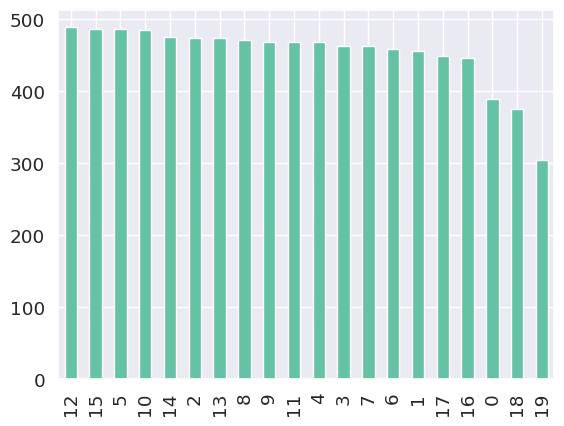

In [9]:
counts = pd.value_counts(train['target'], sort=True)
counts.plot(kind='bar')
plt.show()

Видим, что дисбаланс классов практически отсутствует.

Заметим, что в новостях частыми словами являются артикли, местоимения и предлоги. Они не имеют отношения к тематическим группам, поэтому посмотрим на топ-50 слов в каждой тематической группе длины которых > 5.

In [10]:
# Определим функцию, которая оставляет только слова, длина которых > 5
def filter_words(text):
    pattern = r'\b\w{6,}\b'
    words = re.findall(pattern, text.lower())
    return ' '.join(words)

# Применим функцию filter_words к столбцу text и создадим новый столбец filtered_text
train['filtered_text'] = train['text'].apply(filter_words)
valid['filtered_text'] = valid['text'].apply(filter_words)

In [11]:
counts.index.tolist()

[12, 15, 5, 10, 14, 2, 13, 8, 9, 11, 4, 3, 7, 6, 1, 17, 16, 0, 18, 19]

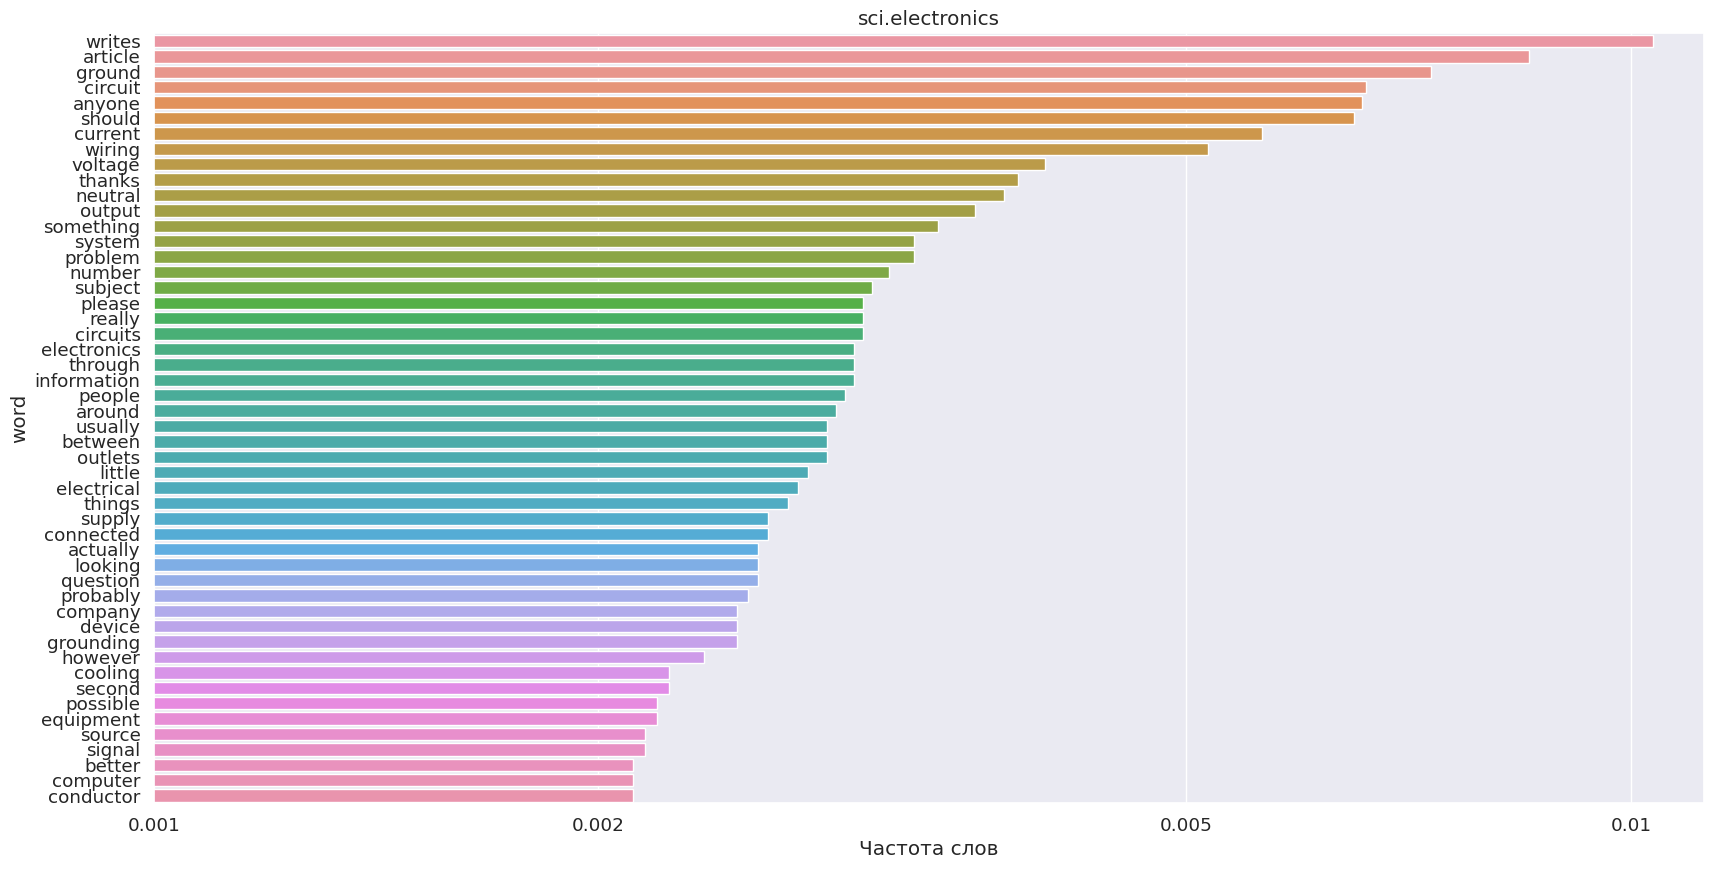

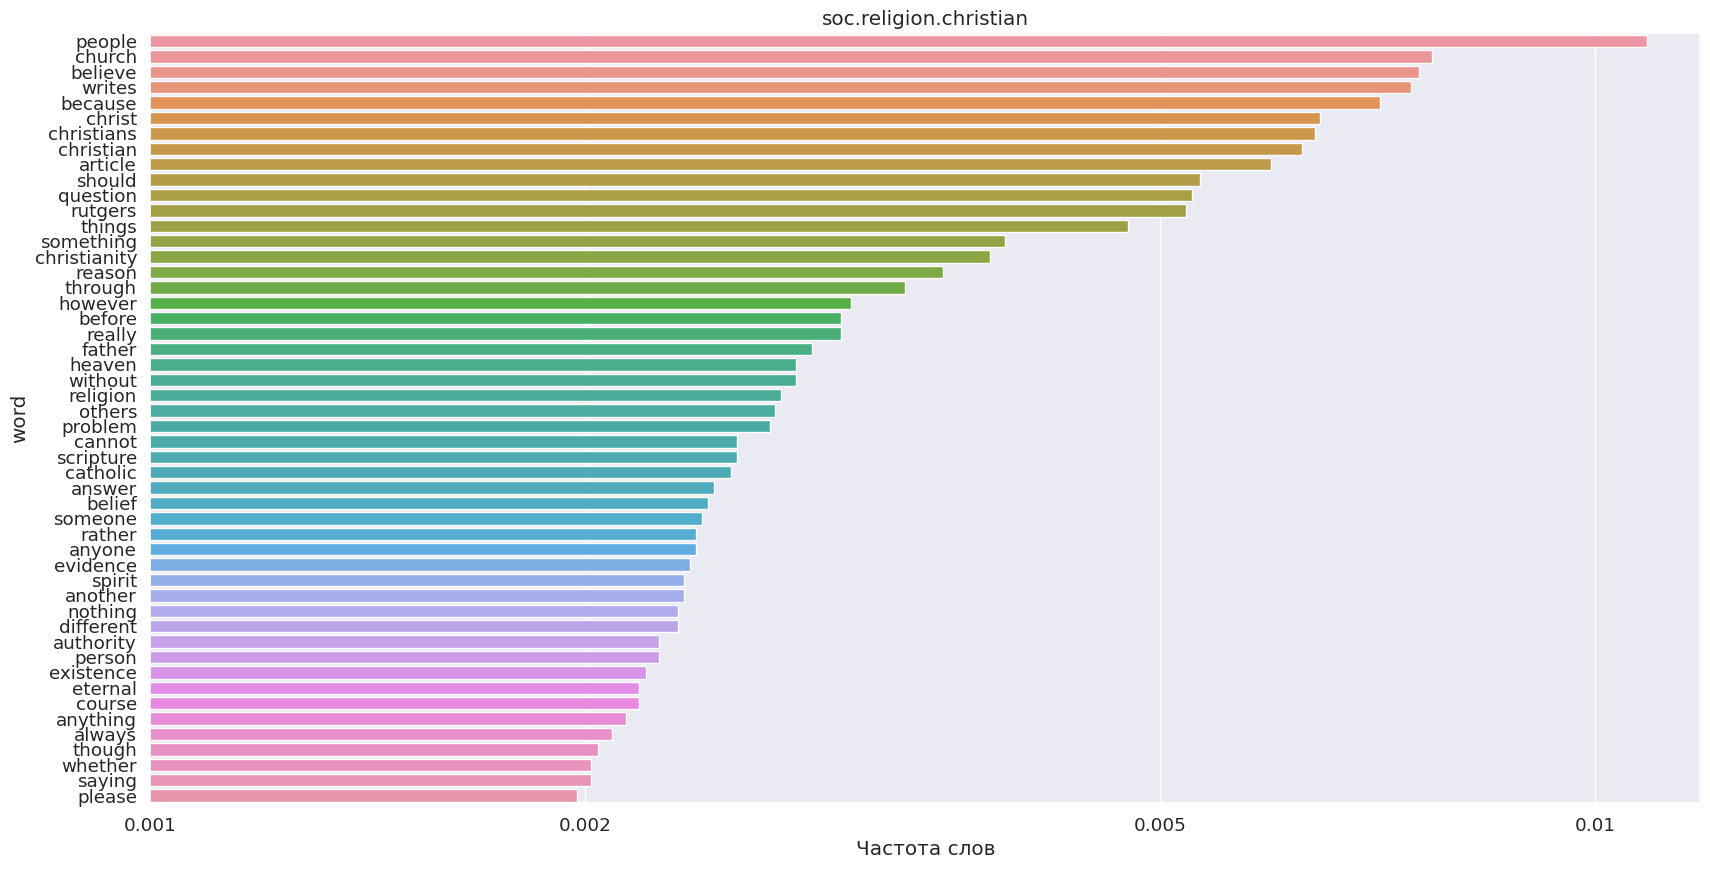

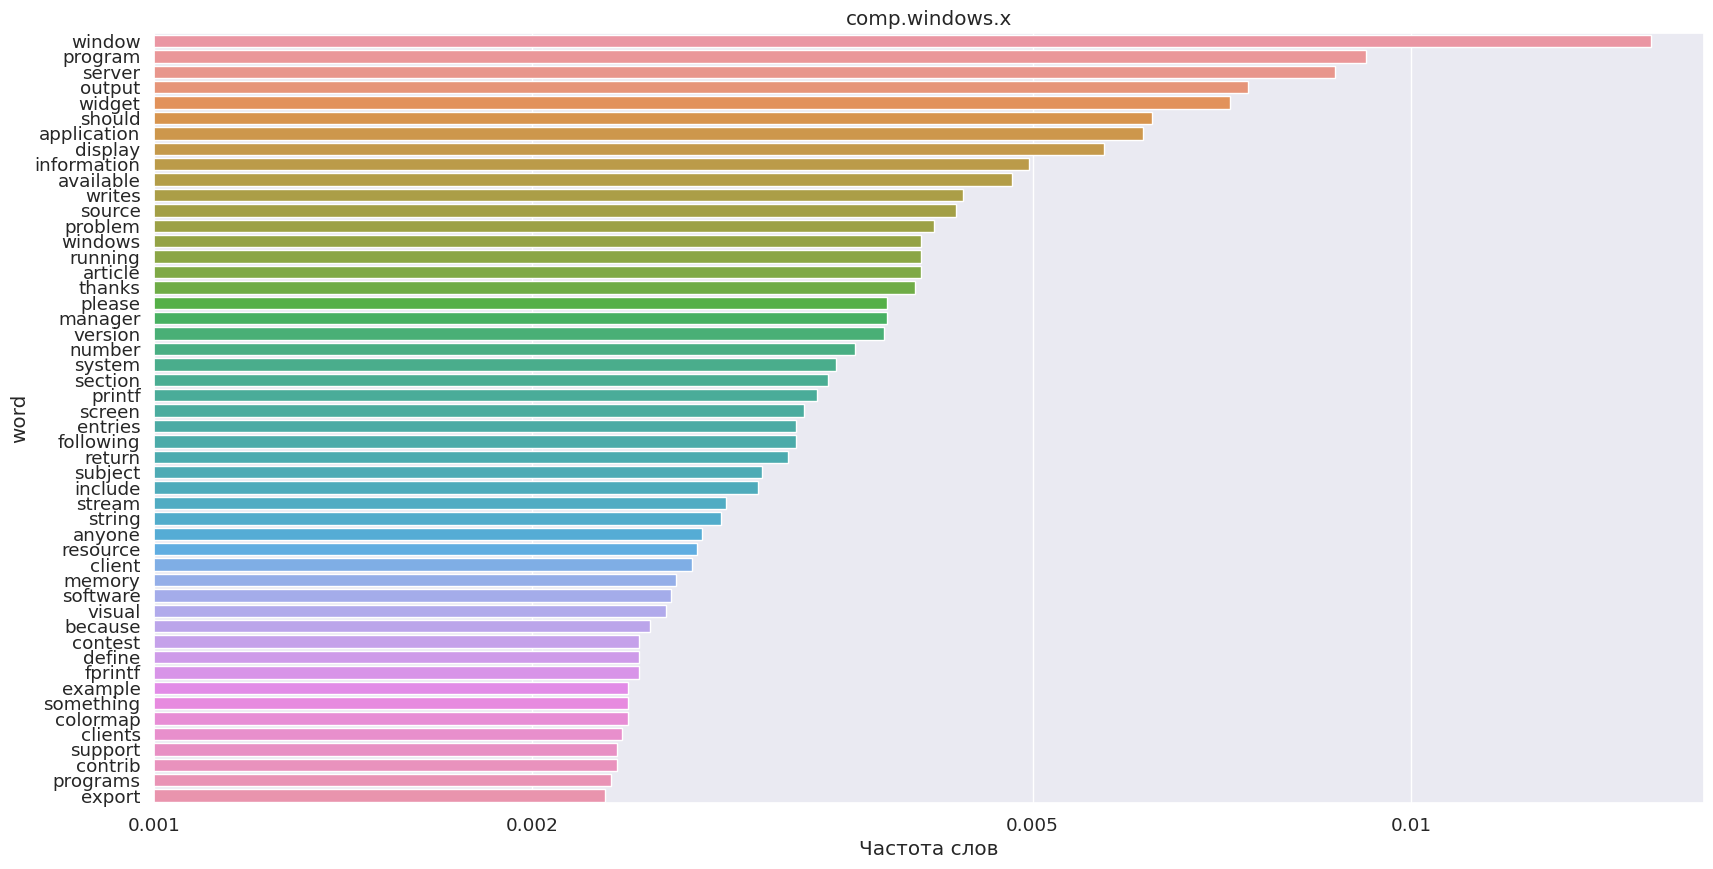

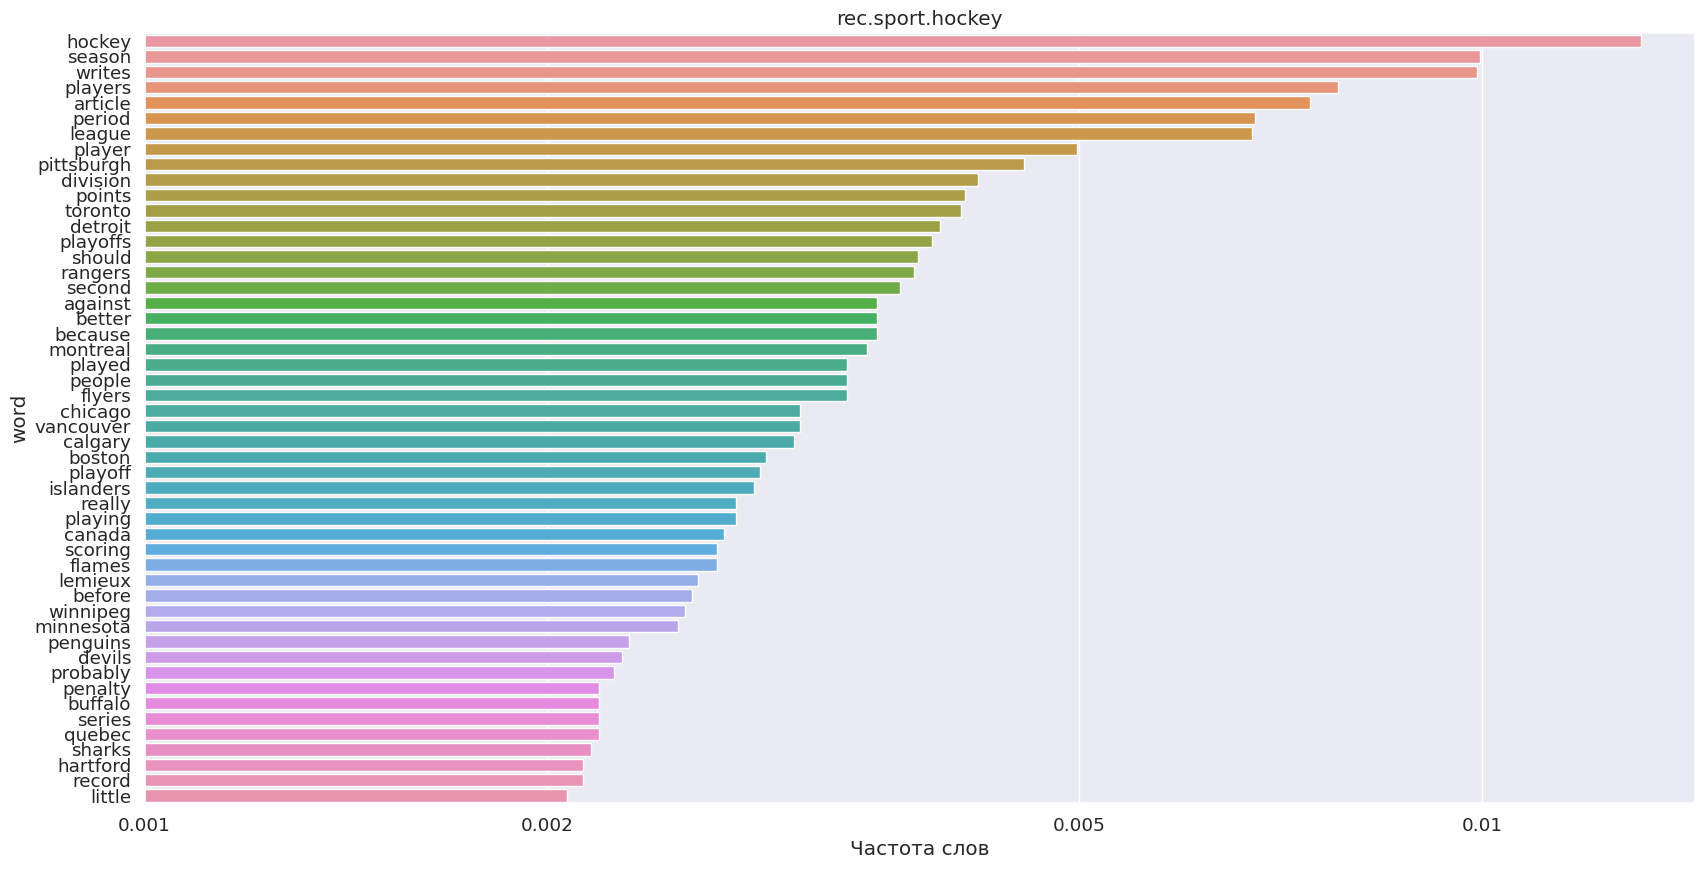

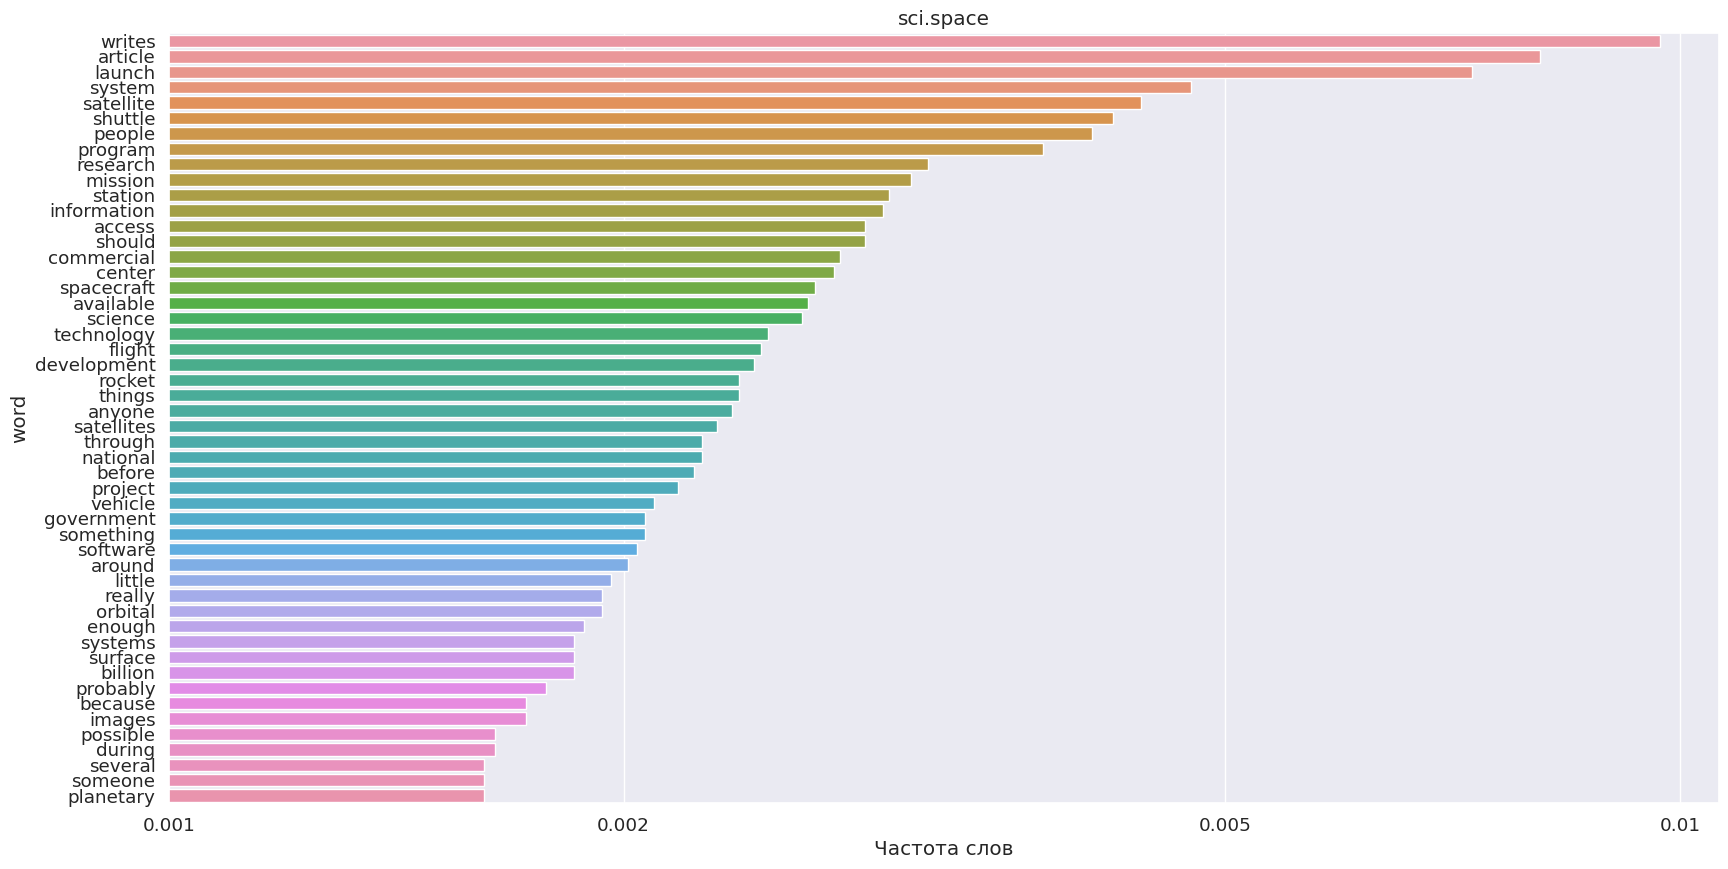

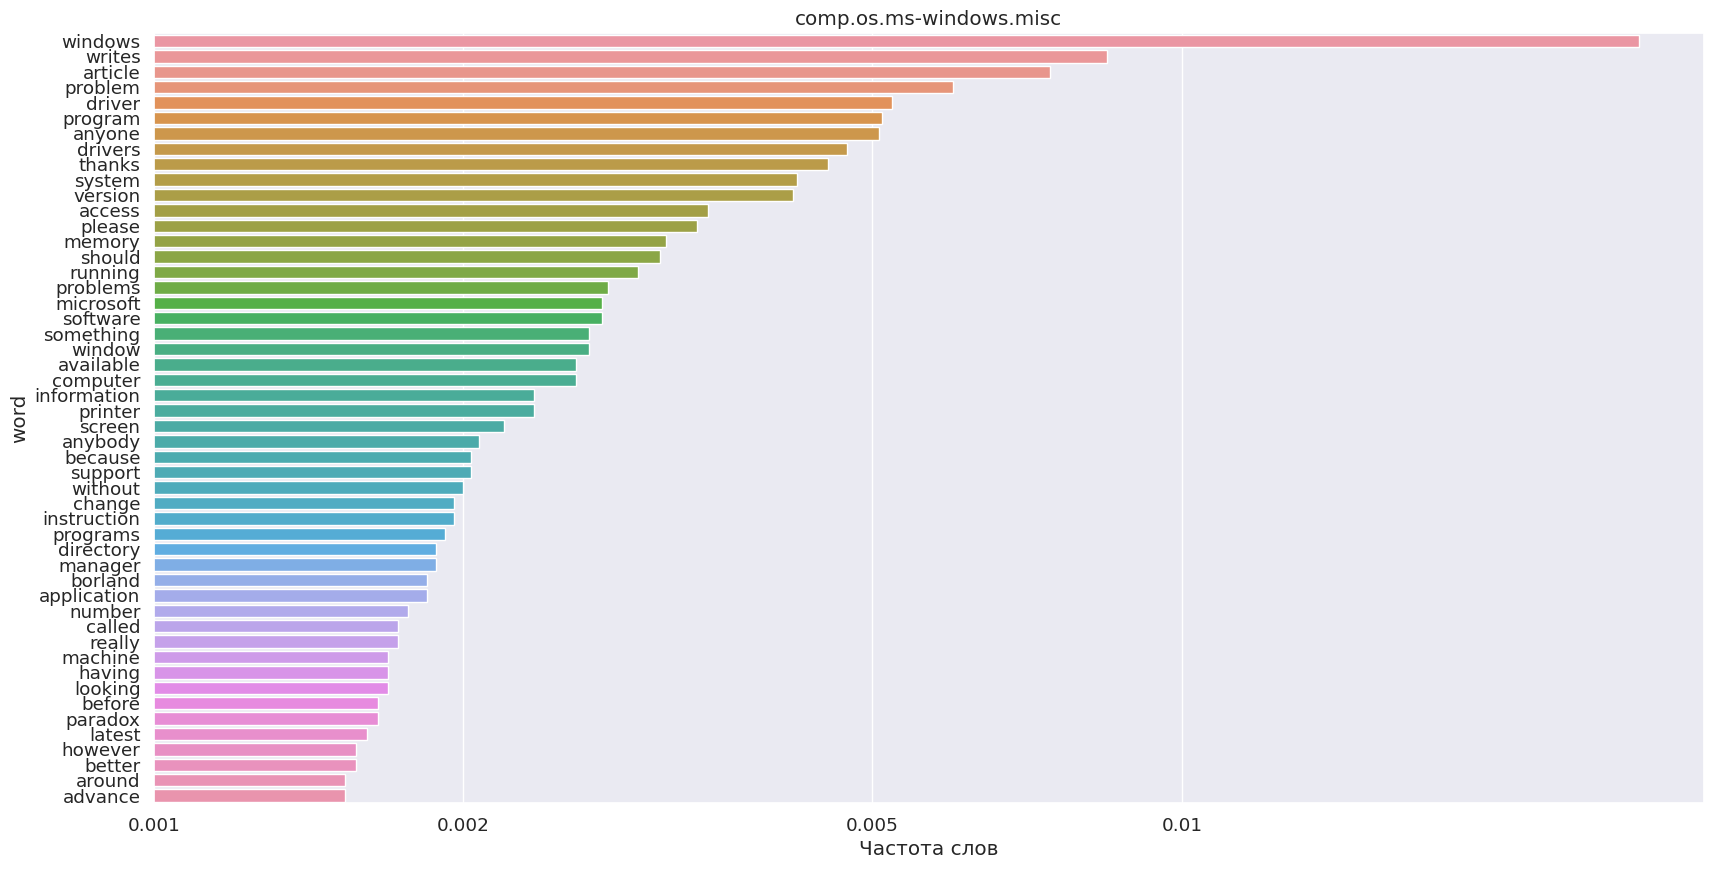

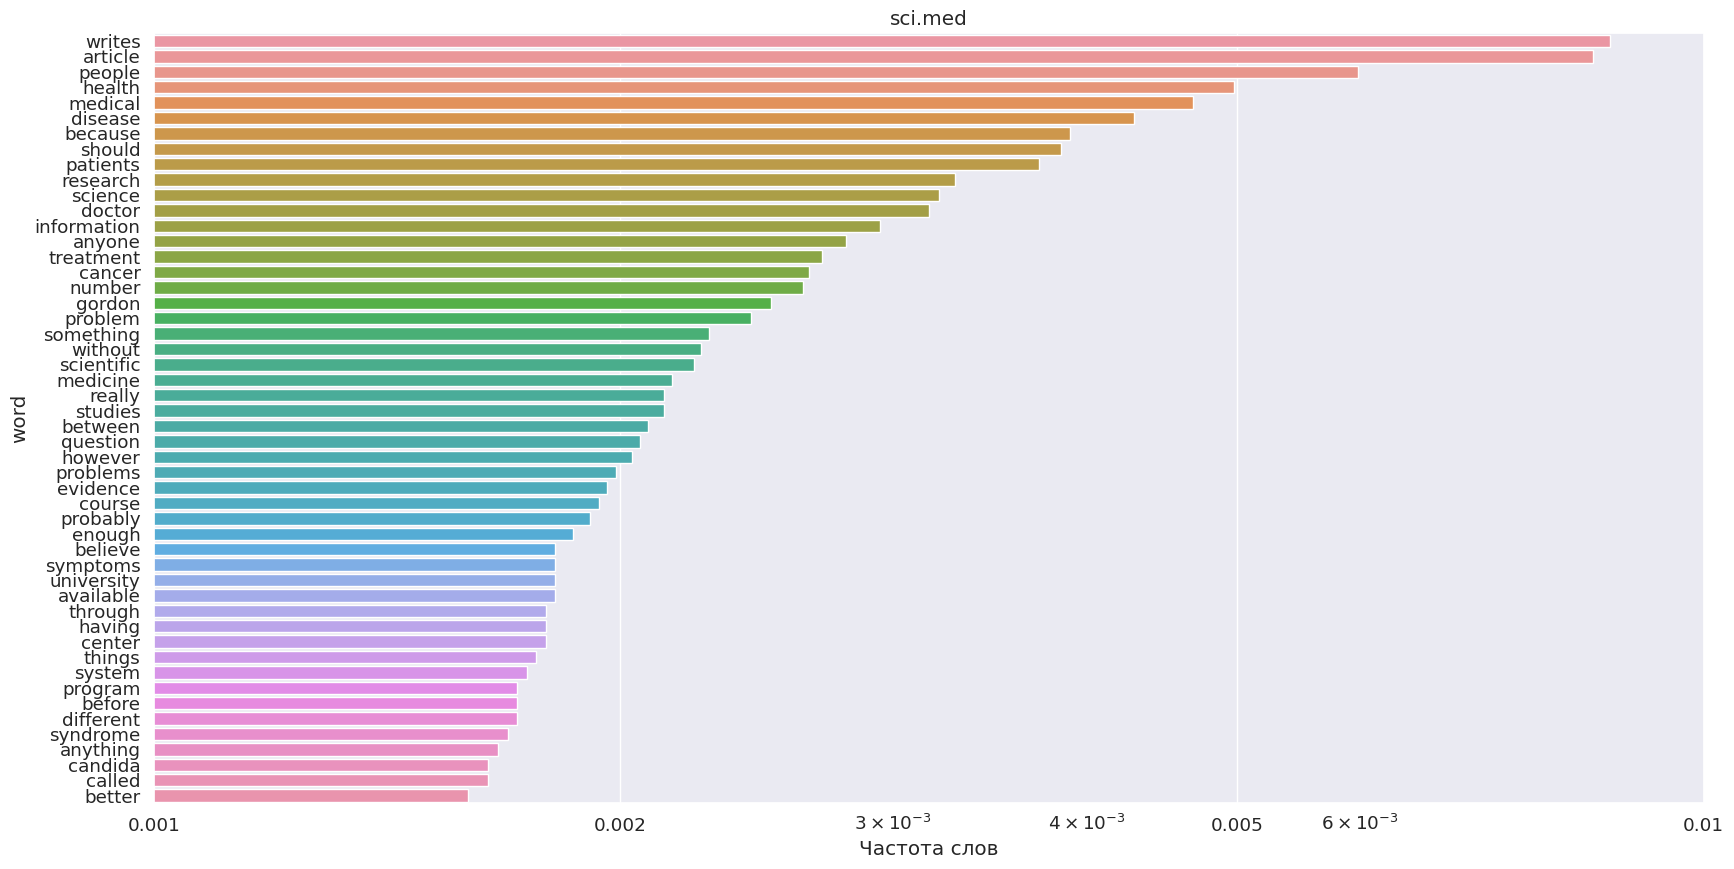

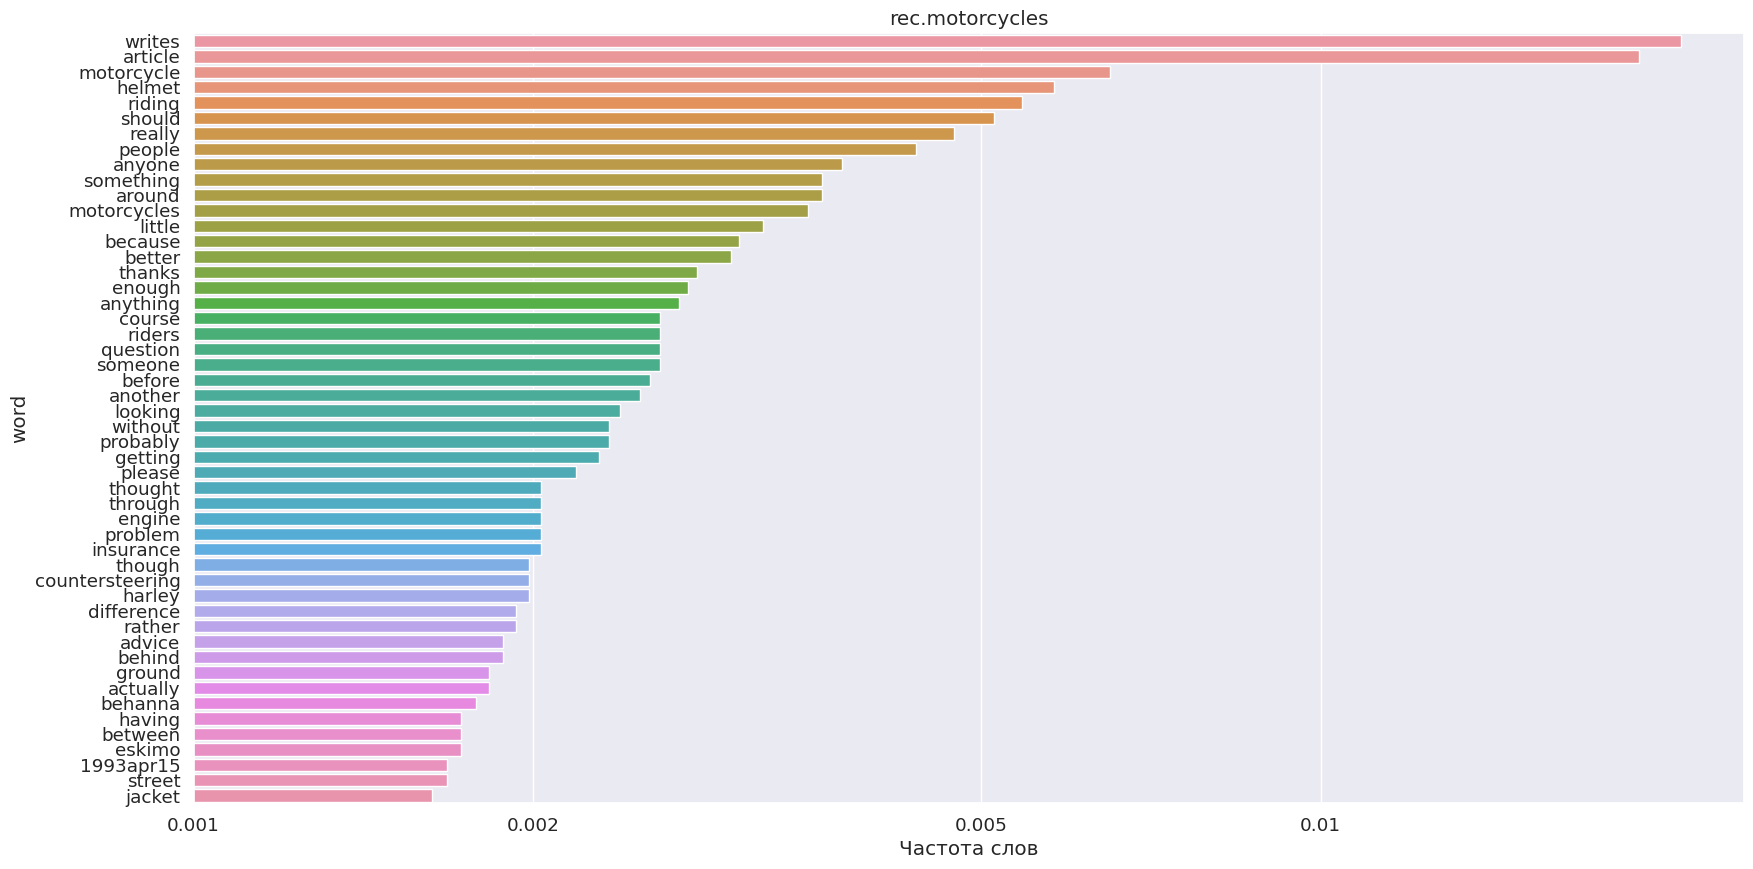

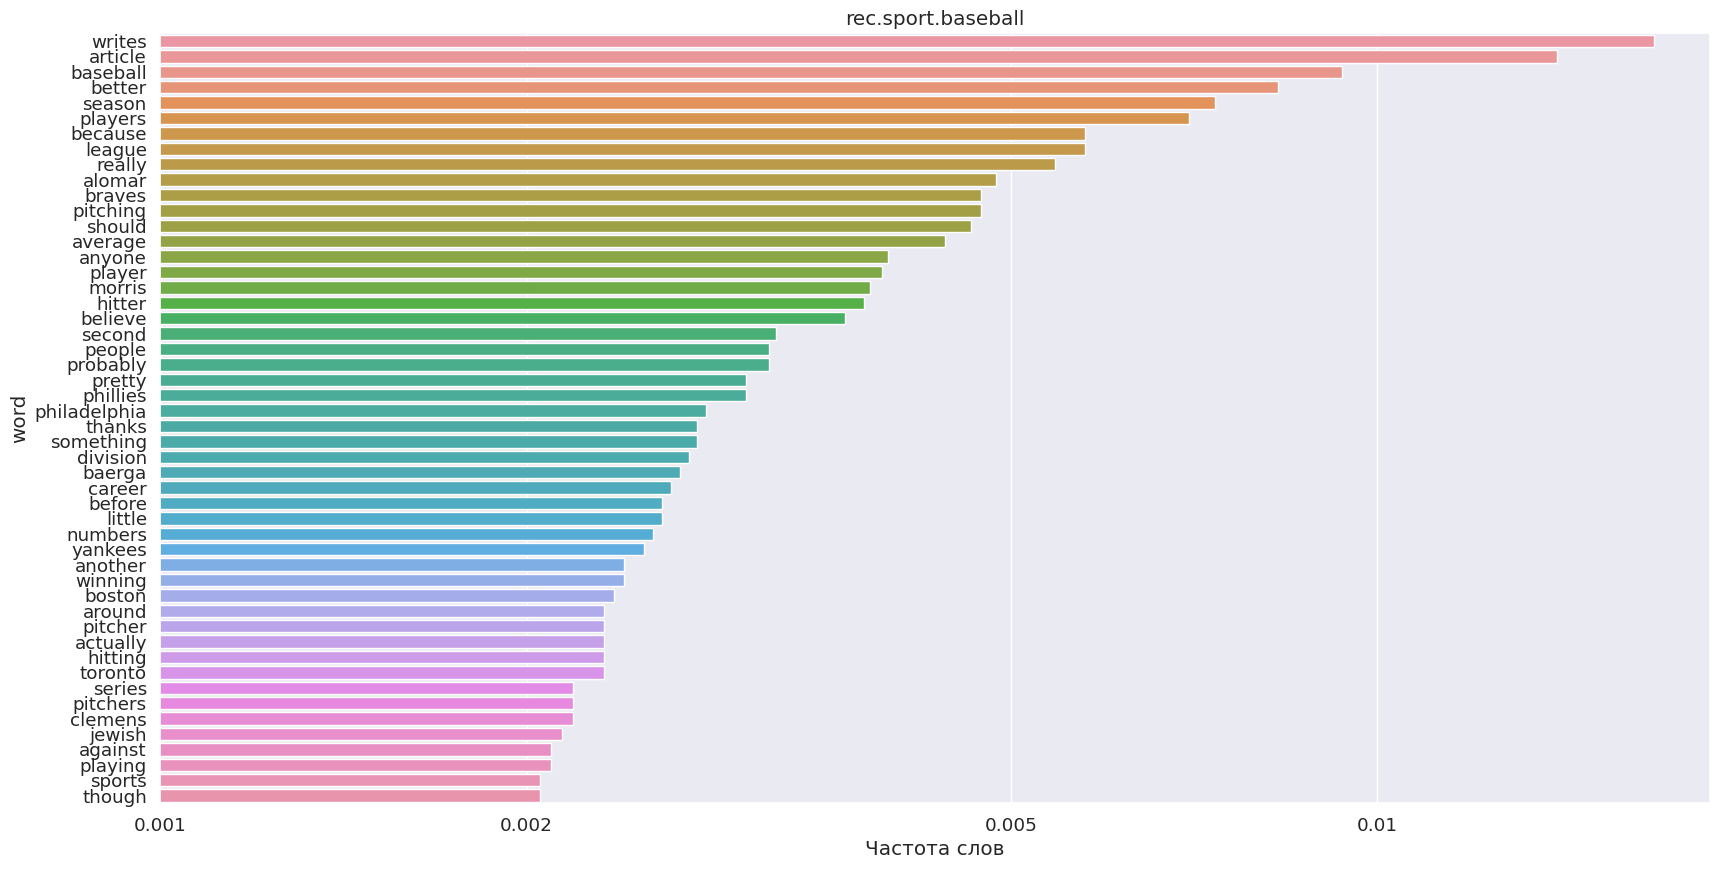

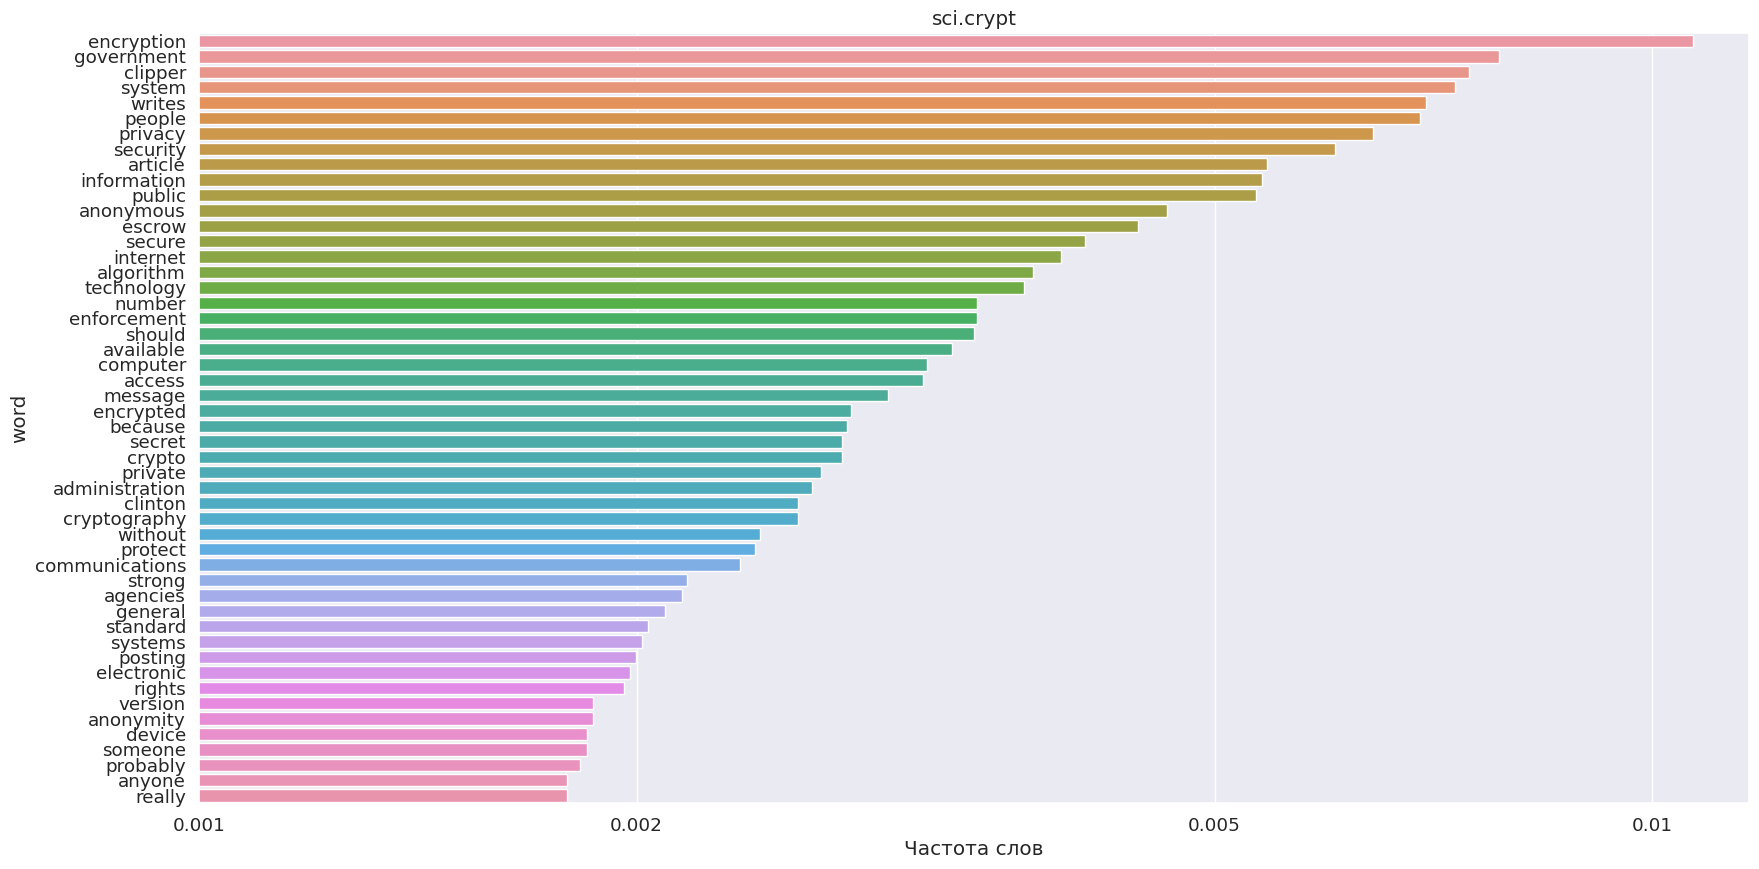

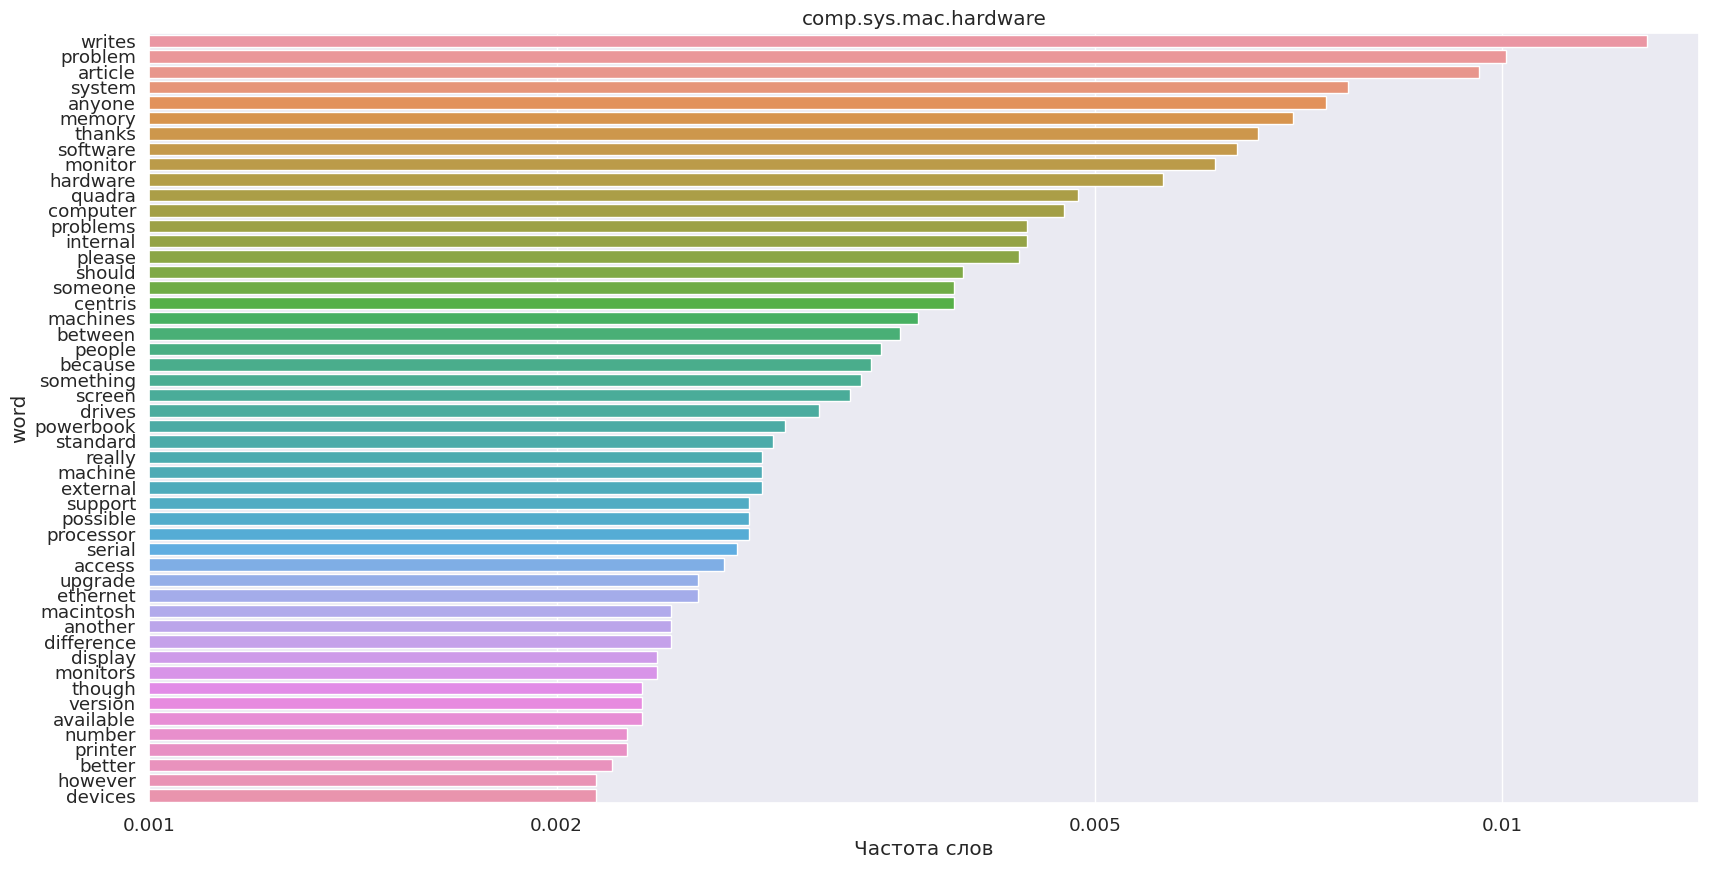

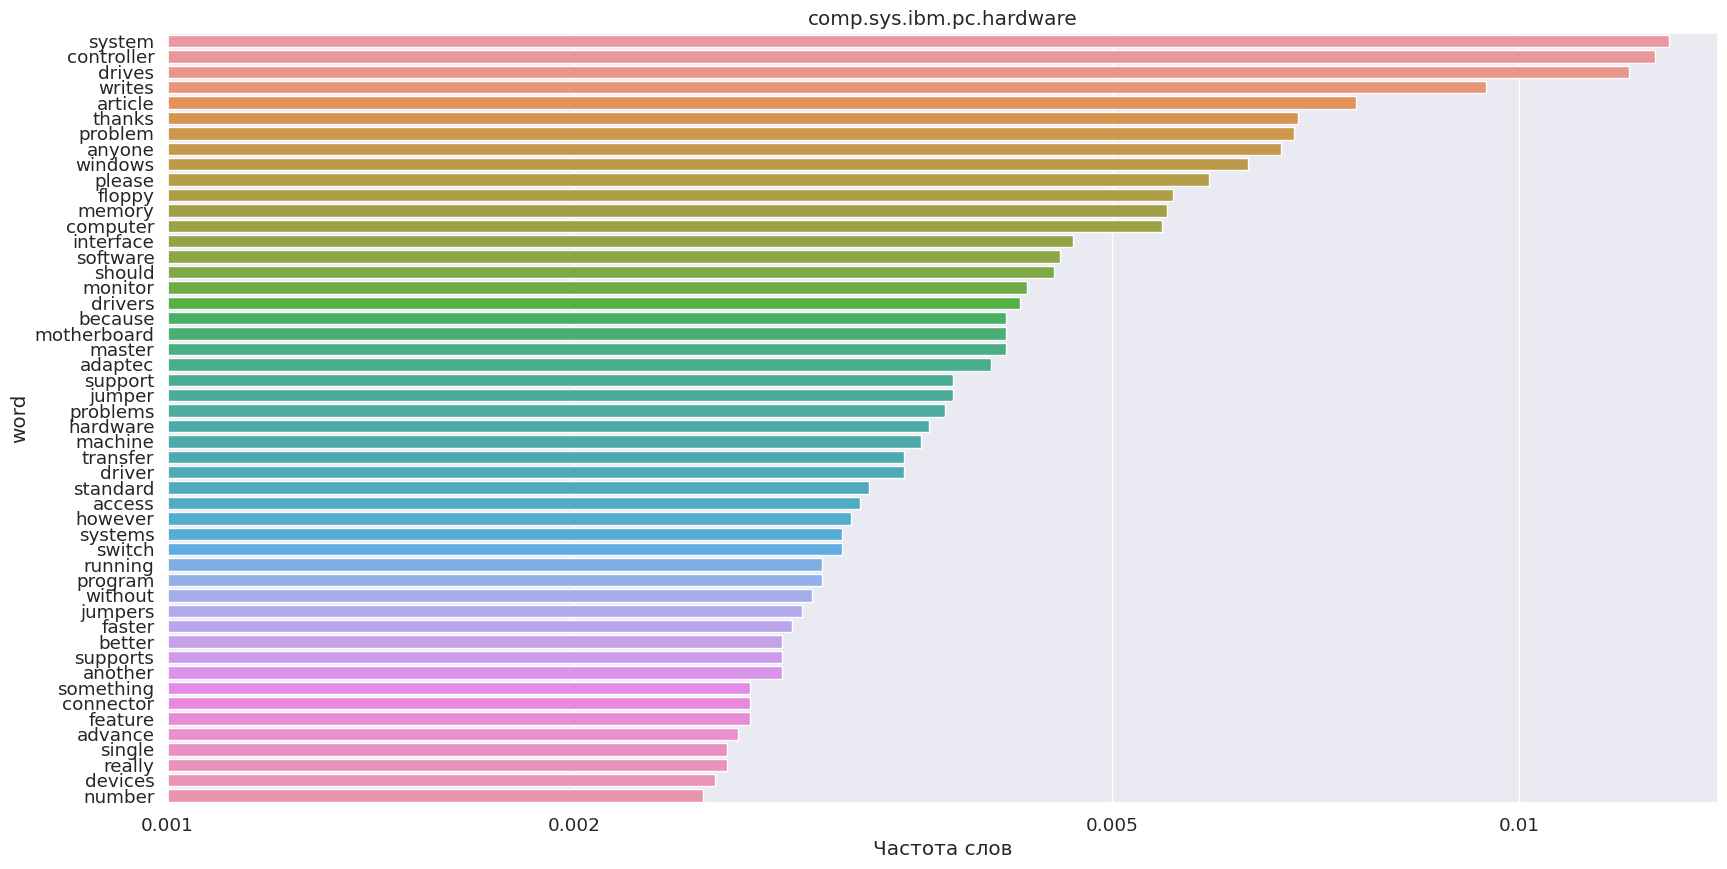

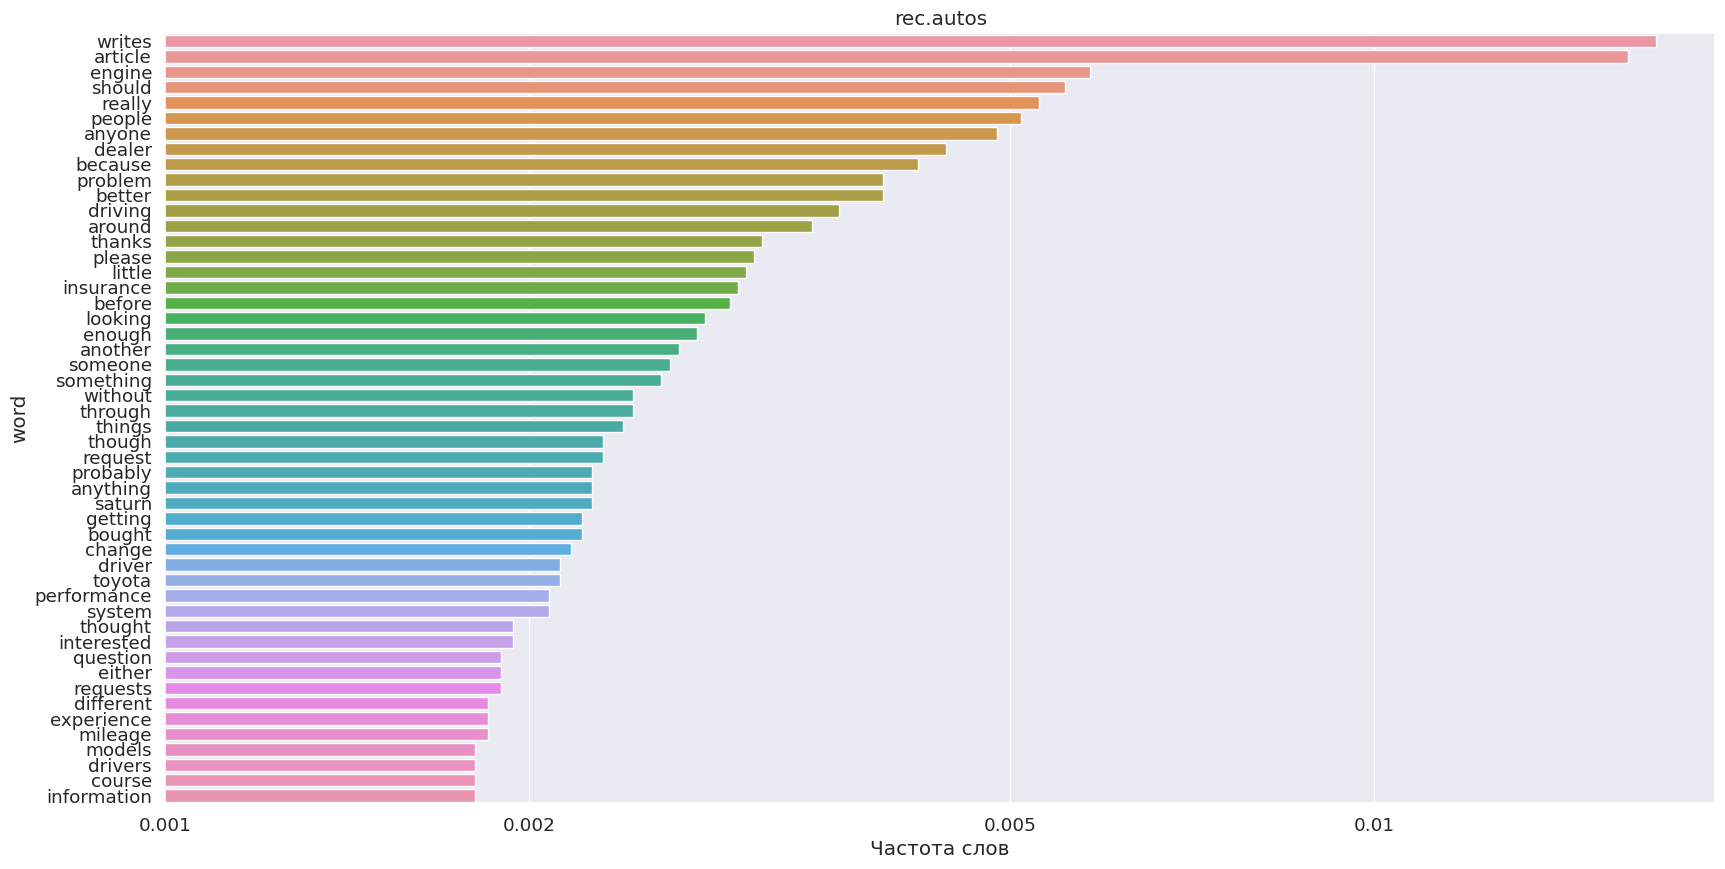

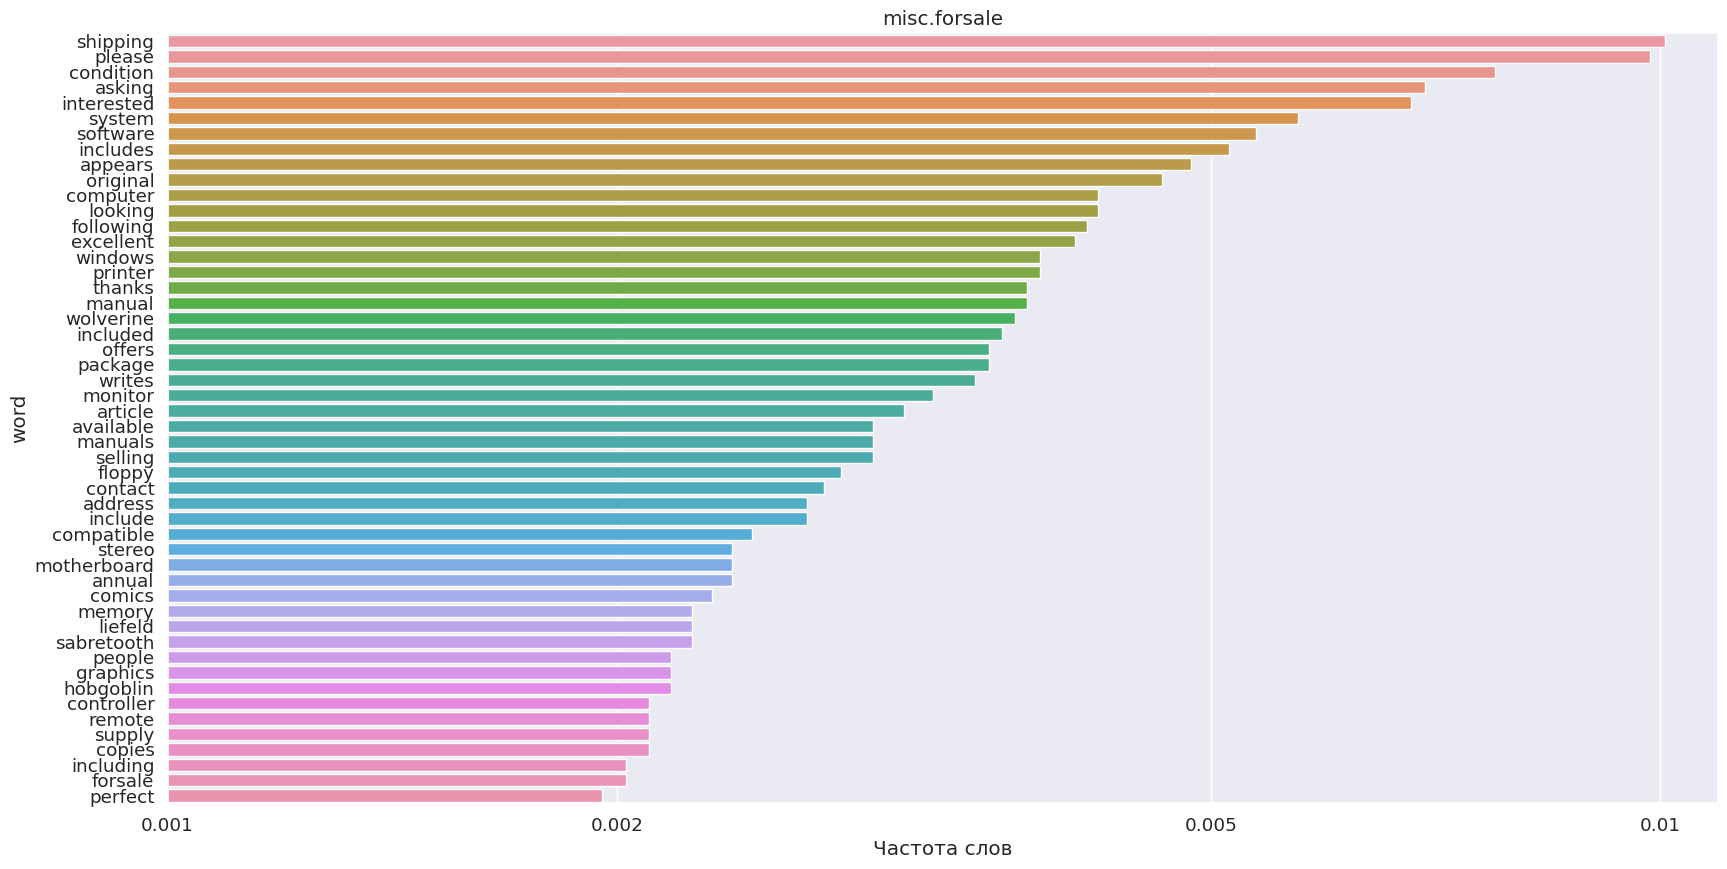

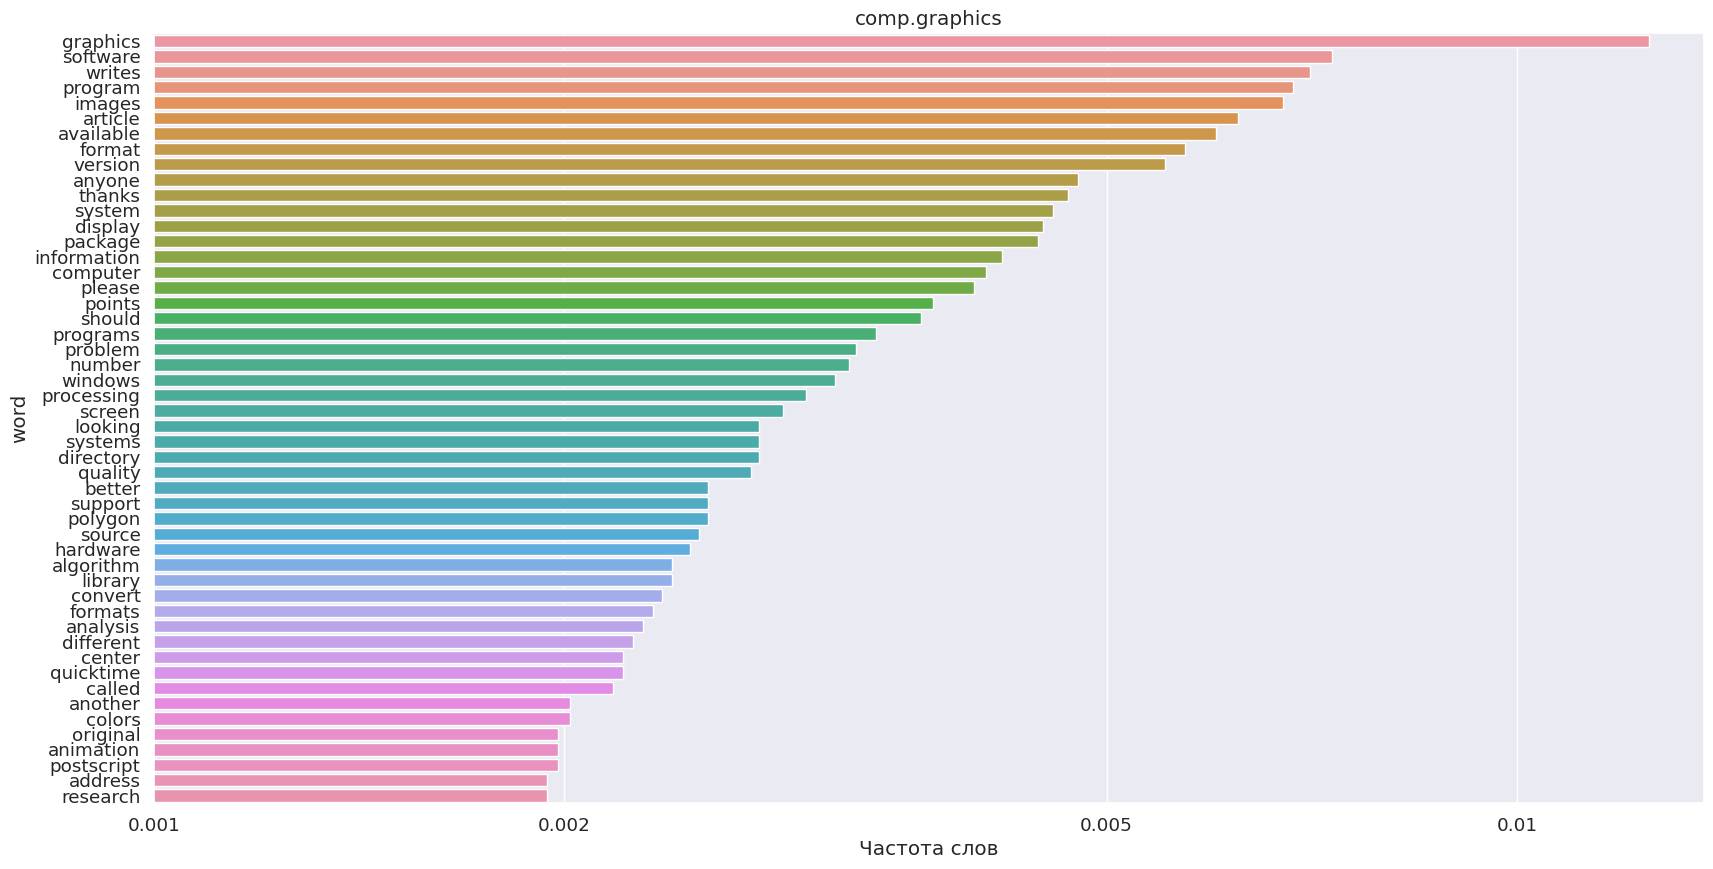

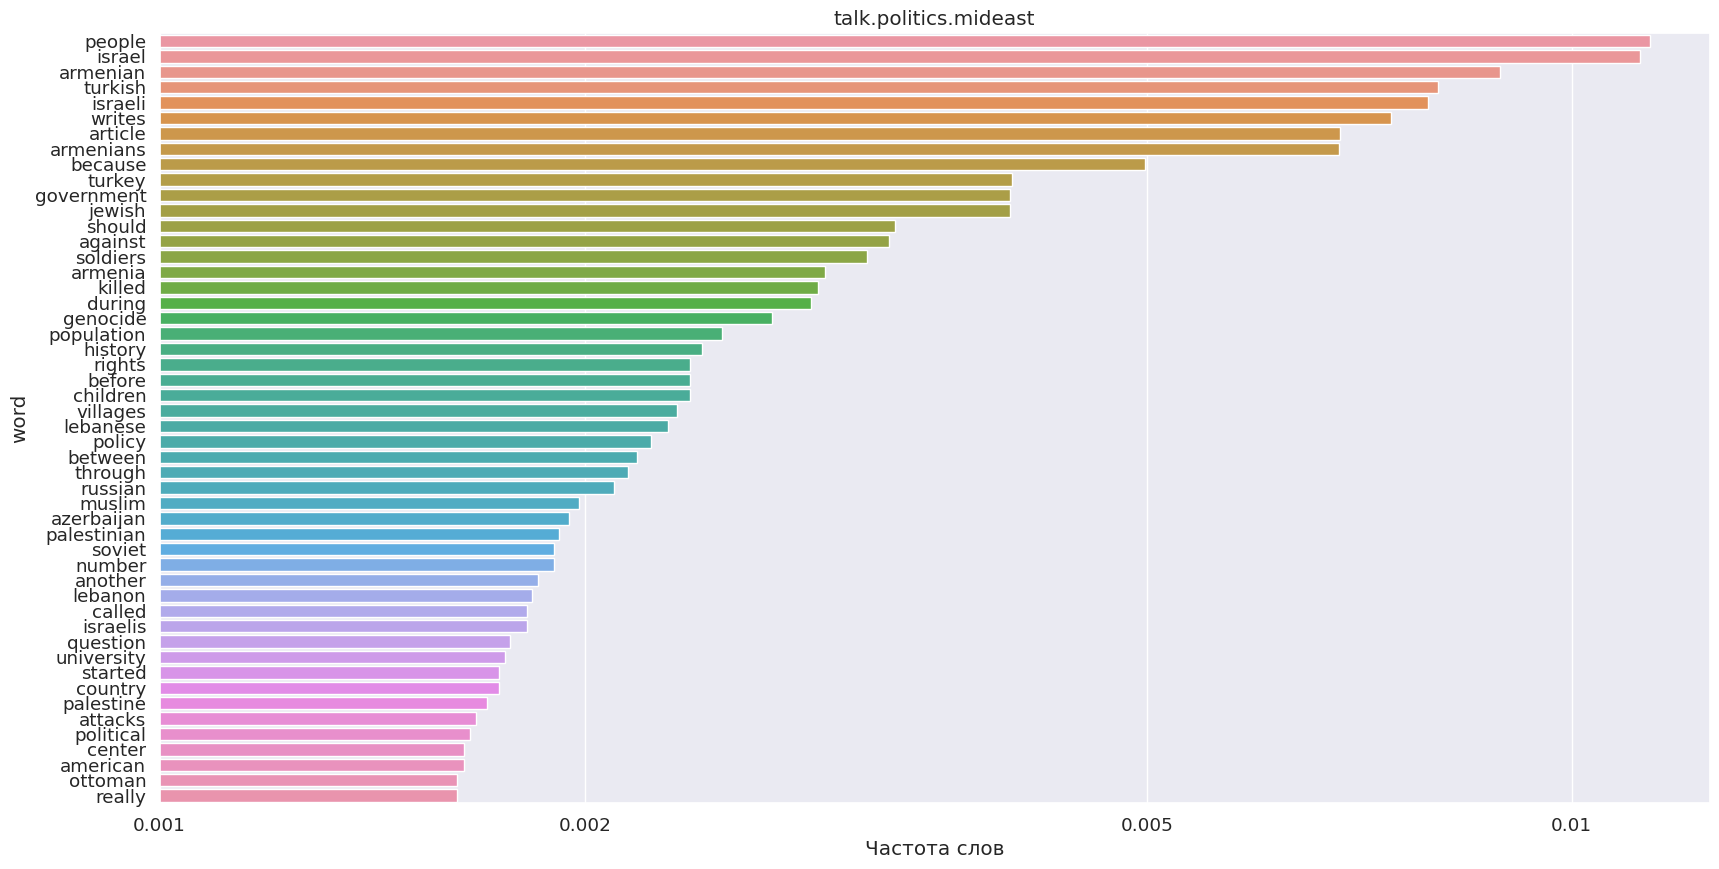

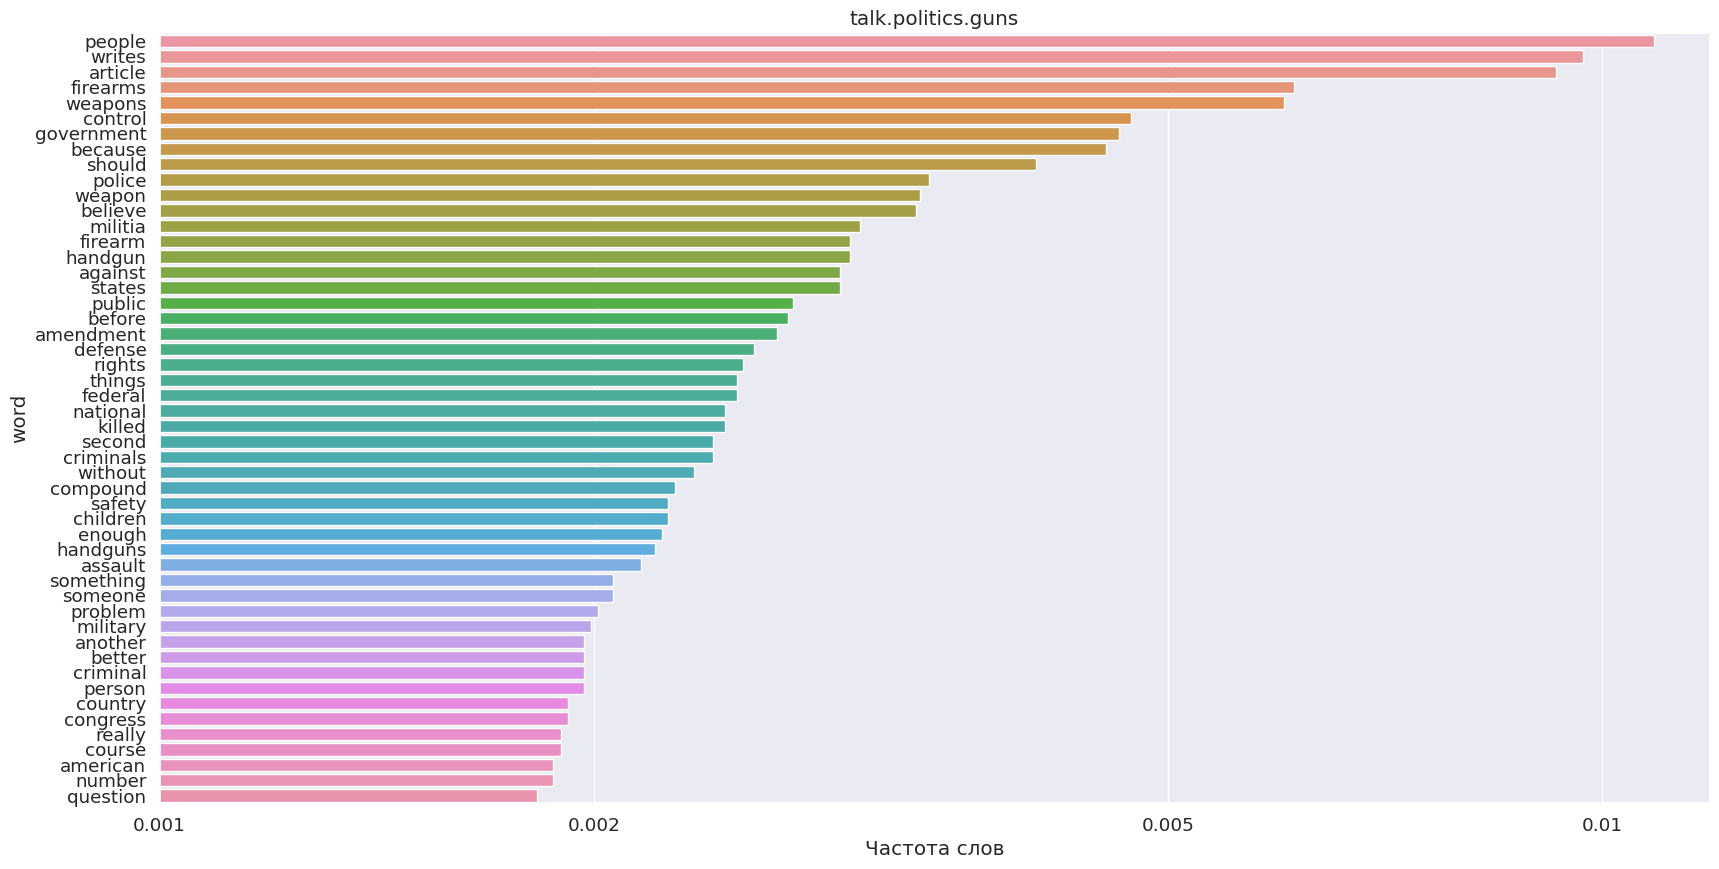

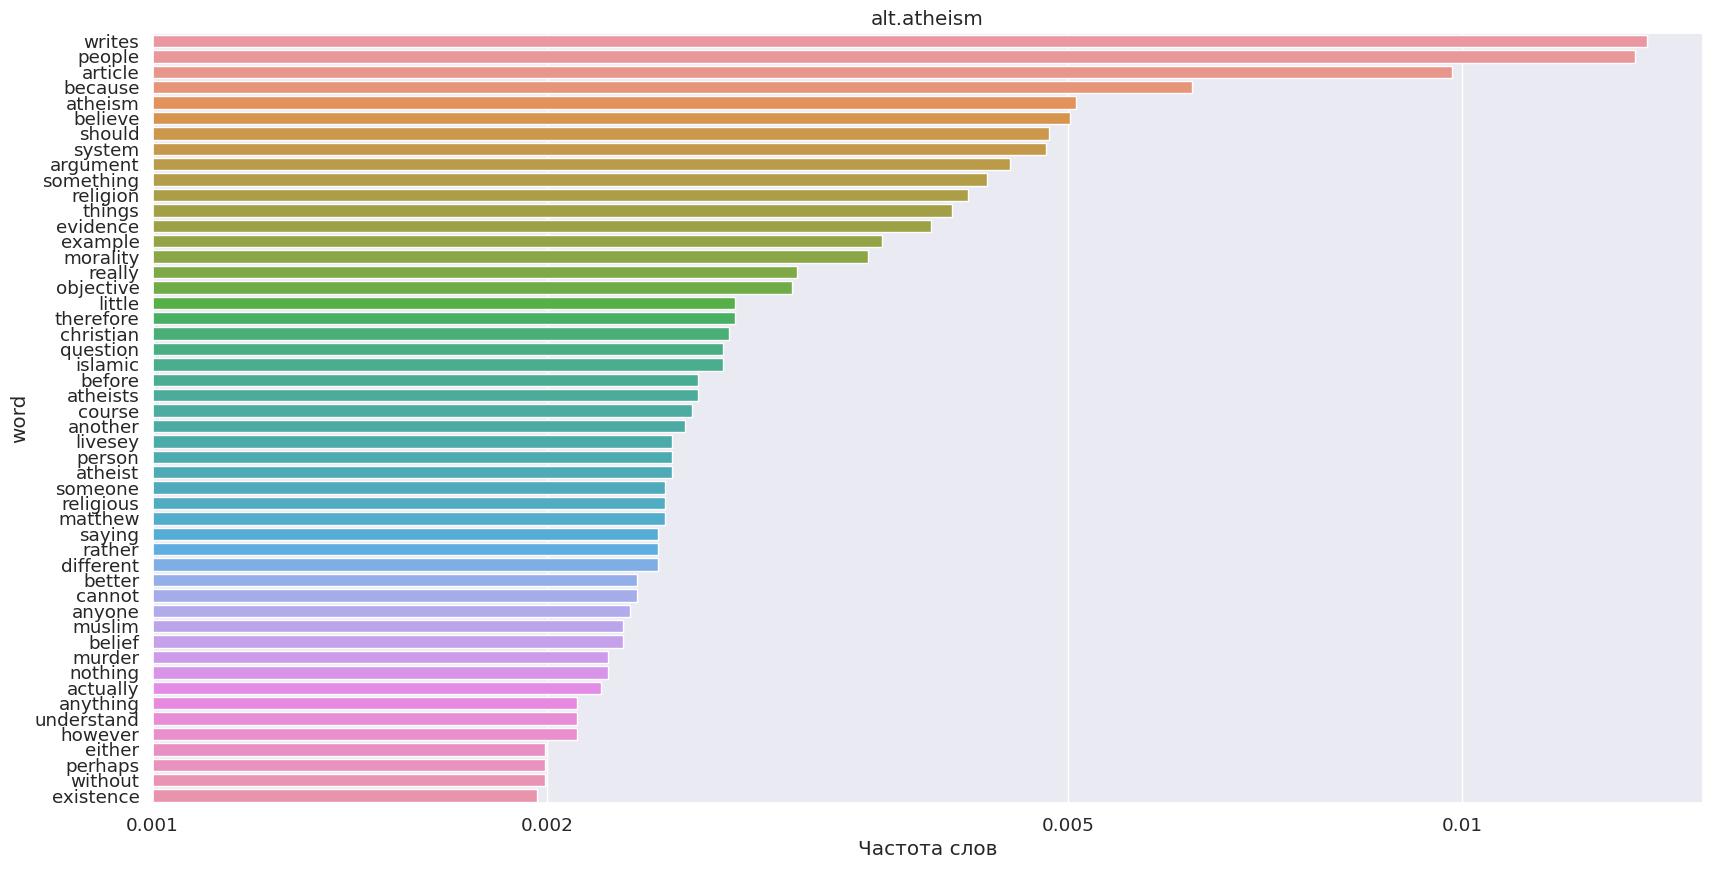

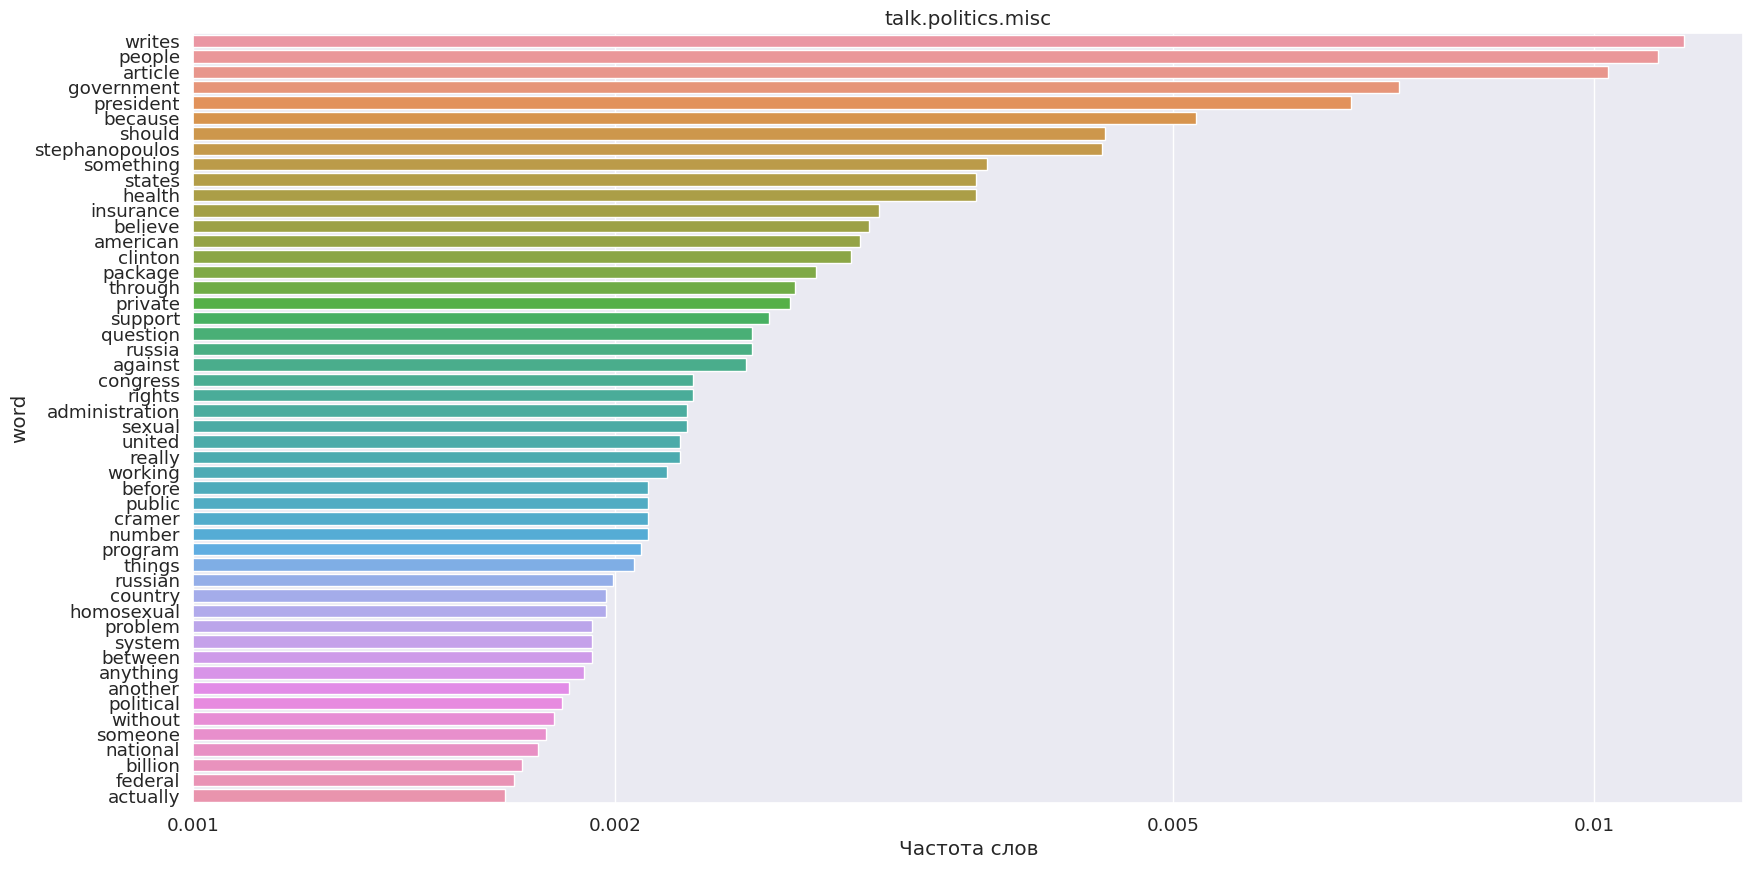

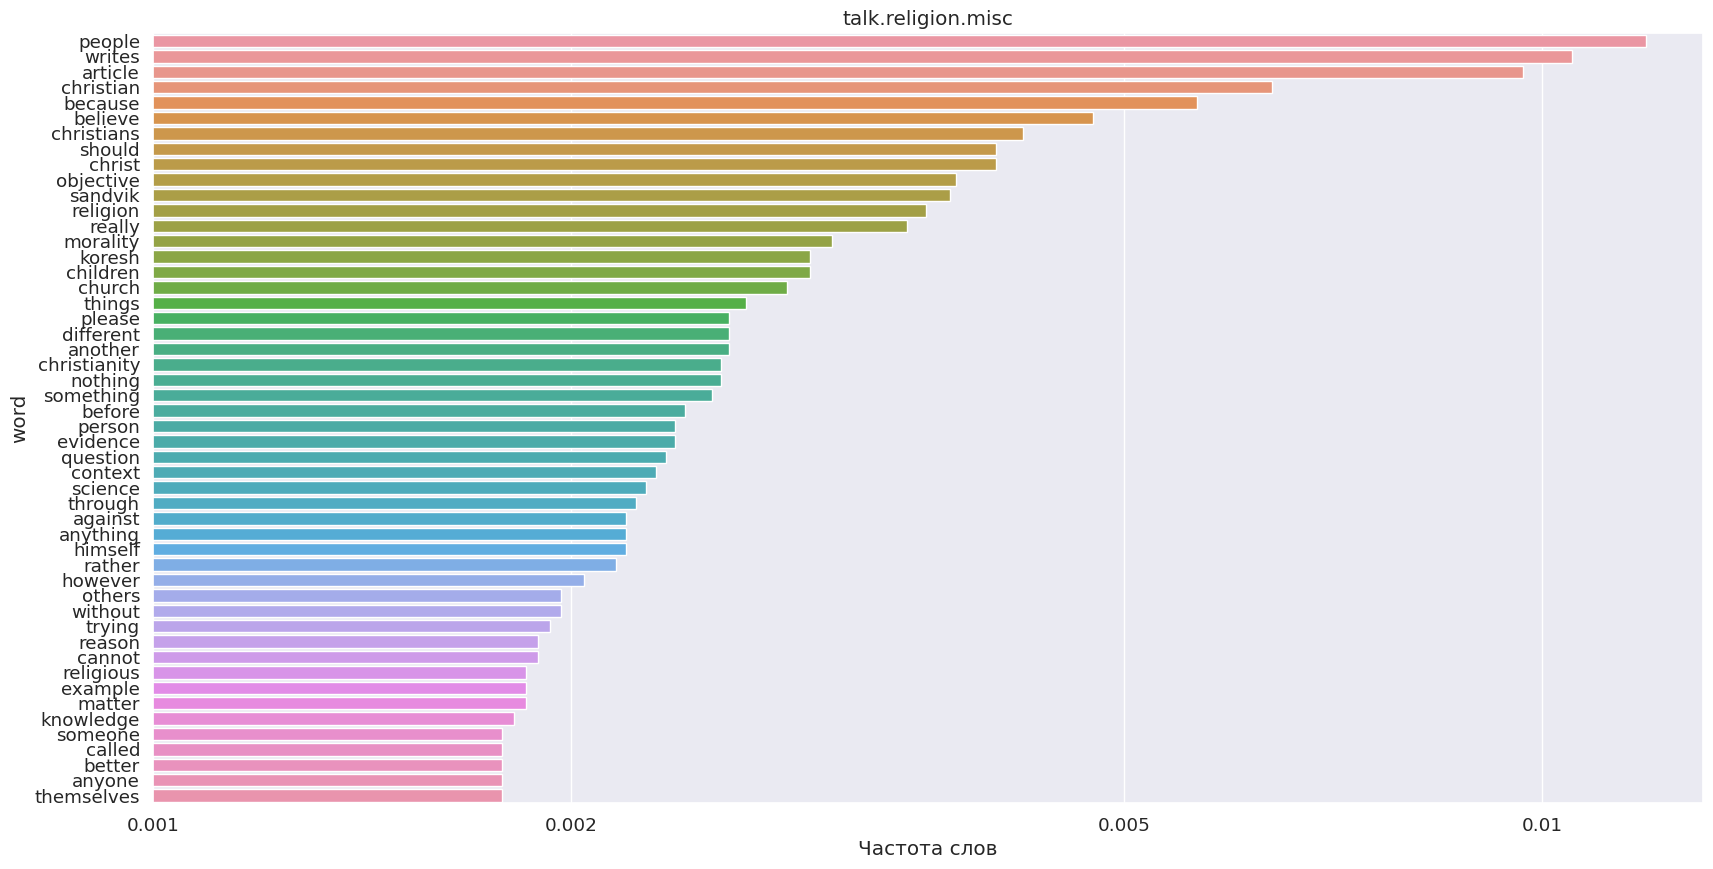

In [12]:
# метки сетки по оси икс
labels = [1e-3, 2e-3, 5e-3, 1e-2]

# для каждой тематической группы
for i, label in enumerate(counts.index.tolist()):
    # извлечем все сообщения и склеим их
    all_words = ' '.join(
        train[train['target'] == label]['filtered_text']
    # приведем к нижнему регистру, удалим точки, разделим на слова
    ).lower().replace('.', '').split()
    # words = [word for word in all_words if len(word) > 5]
    # общее количество слов в этом классе
    words = all_words
    words_count = len(words)

    # посчитаем встречаемость каждого слова и вернем топ-50
    counter = Counter(words).most_common(50)
    counter = pd.DataFrame(counter, columns=['word', 'count'])
  
    plt.figure(figsize=(20, 10))
    
    plt.subplot()
    sns.barplot(y=counter['word'], x=counter['count']/words_count)
    plt.xscale('log')
    plt.xlabel('Частота слов')
    plt.xticks(labels, labels)
    plt.title(data_train['target_names'][label])
    
# plt.tight_layout()
plt.show()

Предобработка данных:

  столбец `target` уже имеет численный вид

  для преобразования текстовых сообщений воспользуемся `CountVectorizer`

In [13]:
vectorizer = CountVectorizer(min_df=0.005, max_df=0.1)
vec_data_train = vectorizer.fit_transform(train['filtered_text']).toarray()
print(vectorizer)

CountVectorizer(max_df=0.1, min_df=0.005)


In [14]:
print(len(vectorizer.get_feature_names_out()))
print(vectorizer.get_feature_names_out()[:100])

1809
['1993apr13' '1993apr14' '1993apr15' '1993apr16' '1993apr17' '1993apr18'
 '1993apr19' '1993apr2' '1993apr20' '1993apr21' '1993apr5' '1993apr6'
 'ability' 'absolute' 'absolutely' 'accept' 'acceptable' 'accepted'
 'access' 'accident' 'according' 'account' 'accounts' 'accurate' 'achieve'
 'across' 'acting' 'action' 'actions' 'active' 'activities' 'activity'
 'actual' 'actually' 'adapter' 'adding' 'addition' 'additional' 'address'
 'addresses' 'addressing' 'administration' 'advance' 'advanced'
 'advantage' 'advice' 'affect' 'affected' 'afford' 'afraid' 'against'
 'agencies' 'agency' 'agents' 'agreed' 'agreement' 'algorithm'
 'algorithms' 'allowed' 'allowing' 'allows' 'almost' 'already'
 'alternative' 'although' 'always' 'amazing' 'amendment' 'america'
 'american' 'americans' 'amount' 'amounts' 'analog' 'analogy' 'analysis'
 'ancient' 'anderson' 'andrew' 'angeles' 'angels' 'animal' 'animals'
 'animation' 'announce' 'announced' 'announcement' 'annoying' 'annual'
 'anonymous' 'answer' 'a

In [15]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, train.target.tolist())

MultinomialNB()

Выполним такие же преобразования над валидационной выборкой

In [16]:
vec_data_valid = vectorizer.transform(valid['text']).toarray()

Посчитаем точность на валидационной выборке

In [17]:
predictions = multinomial_nb.predict(vec_data_valid)
print(f'Точность: {accuracy_score(valid.target.tolist(), predictions) :.3}')

Точность: 0.665


Точность получилась не очень высокая. Вижу несколько способов это исправить. Цель - увеличить размер "мешка слов"

Первый способ: можно оставить слова, длина которых > 3 (артикли, предлоги и большая часть местоимений не попадают в эту категорию)

In [22]:
# Определим функцию, которая оставляет только слова, длина которых > 5
def filter_words(text):
    pattern = r'\b\w{3,}\b'
    words = re.findall(pattern, text.lower())
    return ' '.join(words)

# Применим функцию filter_words к столбцу text и создадим новый столбец filtered_text
train['filtered_text2'] = train['text'].apply(filter_words)
valid['filtered_text2'] = valid['text'].apply(filter_words)

In [120]:
vectorizer = CountVectorizer(min_df=0.001, max_df=0.9)
vec_data_train = vectorizer.fit_transform(train['filtered_text2']).toarray()
print(vectorizer)

CountVectorizer(max_df=0.9, min_df=0.001)


In [121]:
print(len(vectorizer.get_feature_names_out()))
print(vectorizer.get_feature_names_out()[:100])

10702
['000' '001' '0062' '030' '040' '0400' '0qax' '100' '1000' '101' '102'
 '1024' '1024x768' '103' '104' '105' '106' '1069' '107' '108' '109' '10k'
 '10mb' '10th' '110' '1100' '111' '112' '113' '114' '115' '116' '117'
 '1174' '118' '119' '11th' '120' '1200' '121' '122' '123' '124' '125'
 '126' '127' '128' '1280x1024' '129' '12v' '130' '1300' '131' '132' '133'
 '134' '135' '136' '137' '138' '139' '140' '1400' '141' '142' '143' '144'
 '145' '146' '147' '148' '149' '14th' '150' '1500' '151' '152' '153' '155'
 '156' '157' '158' '159' '160' '1600' '161' '162' '163' '164' '165'
 '16550' '168' '169' '16mb' '170' '171' '172' '175' '176' '177']


In [122]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, train.target.tolist())

MultinomialNB()

In [123]:
vec_data_valid = vectorizer.transform(valid['text']).toarray()

In [124]:
predictions = multinomial_nb.predict(vec_data_valid)
print(f'Точность: {accuracy_score(valid.target.tolist(), predictions) :.3}')

Точность: 0.818


Второй способ: уменьшить минимальную долю сообщений в "мешке слов" на несколько порядков

In [18]:
vectorizer2 = CountVectorizer(min_df=0.0005, max_df=0.05)
vec_data_train = vectorizer2.fit_transform(train['filtered_text']).toarray()
print(len(vectorizer2.get_feature_names_out()))
print(vectorizer2.get_feature_names_out()[:100])

11781
['000152' '001319' '021021' '024222' '024246' '0tbxom' '100mhz' '1024x768'
 '1024x768x256' '122758' '1280x1024' '130mph' '13404334aej7d' '144750'
 '14691229' '1483500348' '1483500349' '1483500354' '15apr93' '168730'
 '170731' '175334' '18084tm' '184448' '18apr93' '190493200420' '19930419'
 '1993apr06' '1993apr1' '1993apr10' '1993apr11' '1993apr12' '1993apr13'
 '1993apr14' '1993apr15' '1993apr16' '1993apr17' '1993apr18' '1993apr19'
 '1993apr2' '1993apr20' '1993apr21' '1993apr22' '1993apr23' '1993apr24'
 '1993apr25' '1993apr26' '1993apr3' '1993apr4' '1993apr5' '1993apr6'
 '1993apr7' '1993apr8' '1993apr9' '1993mar24' '1993mar26' '1993mar29'
 '1993mar30' '1993mar31' '1eqtct' '1f9f9f' '1qpg8finn982' '1qu8ud'
 '1r19tp' '1r6g8finne88' '1rd7eo' '1z6ei0l' '203620' '205615'
 '20apr199301460499' '211353' '211638' '225707pp3903a' '231049u28037'
 '2a42dubinski' '2bce0918' '2de145' '2dm75u' '2tcv9f0' '300x300' '320x200'
 '337523' '337548' '34aej7d' '386bsd' '386max' '3v9f9d' '3v9f9f9' '486dx2'

In [19]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, train.target.tolist())

MultinomialNB()

In [20]:
vec_data_valid = vectorizer2.transform(valid['text']).toarray()
predictions = multinomial_nb.predict(vec_data_valid)
print(f'Точность: {accuracy_score(valid.target.tolist(), predictions) :.3}')

Точность: 0.798


Давайте посмотрим к чему приведет объединение двух способов

In [23]:
vectorizer3 = CountVectorizer(min_df=0.0005, max_df=0.05)
vec_data_train = vectorizer3.fit_transform(train['filtered_text2']).toarray()
print(len(vectorizer3.get_feature_names_out()))
print(vectorizer3.get_feature_names_out()[:100])

17952
['000' '000152' '001' '001319' '0062' '014' '020' '0200' '021021' '02139'
 '0223' '024222' '024246' '030' '0300' '0358' '040' '0400' '0500' '0666'
 '0863' '0ha' '0iv' '0m75u' '0qax' '0qq' '0tbxn' '0tbxom' '0tq' '100'
 '1000' '10000' '100k' '100mhz' '101' '1013' '1016' '102' '1020' '1024'
 '1024x768' '1024x768x256' '103' '104' '1045' '105' '106' '1069' '107'
 '1074' '108' '109' '10k' '10mb' '10mhz' '10th' '110' '1100' '111' '11181'
 '112' '112f' '113' '114' '11467' '115' '1150' '116' '117' '1174' '118'
 '119' '11th' '120' '1200' '120mb' '121' '122' '122758' '123' '124' '125'
 '126' '127' '128' '1280' '1280x1024' '128k' '129' '12mb' '12v' '130'
 '1300' '1304' '130mph' '131' '132' '133' '1333' '134']


In [25]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, train.target.tolist())

MultinomialNB()

In [26]:
vec_data_valid = vectorizer3.transform(valid['text']).toarray()
predictions = multinomial_nb.predict(vec_data_valid)
print(f'Точность: {accuracy_score(valid.target.tolist(), predictions) :.3}')

Точность: 0.837


Точность стала выше чем в каждом из способов по отдельности!

Попробуем уменьшить минимальную долю сообщений в "мешке слов" еще на несколько порядков.

In [33]:
vectorizer4 = CountVectorizer(min_df=0.00005, max_df=0.05)
vec_data_train = vectorizer4.fit_transform(train['filtered_text2']).toarray()
print(len(vectorizer4.get_feature_names_out()))
print(vectorizer4.get_feature_names_out()[:100])

99848
['000' '0000' '00000' '000000' '00000000' '0000000004' '00000000b'
 '00000001' '00000001b' '00000010' '00000010b' '00000011' '00000011b'
 '00000074' '00000093' '000000e5' '00000100' '00000100b' '00000101'
 '00000101b' '00000110' '00000110b' '00000111' '00000111b' '000005102000'
 '00000510200001' '000007' '00000ee5' '00001000' '00001000b' '00001001'
 '00001001b' '00001010' '00001010b' '00001011' '00001011b' '000010af'
 '00001100' '00001100b' '00001101' '00001101b' '00001110' '00001110b'
 '00001111' '00001111b' '000021' '000042' '000062david42' '000094' '0001'
 '00010000' '00010000b' '00010001' '00010001b' '00010010' '00010010b'
 '00010011' '00010011b' '000100255pixel' '00010100' '00010100b' '00010101'
 '00010101b' '00010110' '00010110b' '00010111' '00010111b' '00011000'
 '00011000b' '00011001' '00011001b' '00011010' '00011010b' '00011011'
 '00011011b' '00011100' '00011100b' '00011101' '00011101b' '00011110'
 '00011110b' '00011111' '00011111b' '000152' '0001mpc' '0001x7c' '0002'
 '

In [34]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, train.target.tolist())

MultinomialNB()

In [35]:
vec_data_valid = vectorizer4.transform(valid['text']).toarray()
predictions = multinomial_nb.predict(vec_data_valid)
print(f'Точность: {accuracy_score(valid.target.tolist(), predictions) :.3}')

Точность: 0.832


Посчитайте качество на тестовой выборке.

Для начала преобразуем данные в тестовой выборке, как уже было сделано с тренировочными и валидационными данными.

In [37]:
df = pd.DataFrame([data_test.data, data_test.target.tolist()]).T
df.columns = ['text', 'target']

targets = pd.DataFrame(data_test.target_names)
targets.columns=['title']

test = pd.merge(df, targets, left_on='target', right_index=True)
test.head()

,text,target,title
0,I am a little confused on all of the models of...,7,rec.autos
27,I have a 90 Eagle Talon and I wanted a pair of...,7,rec.autos
28,"Hi,\nI need your help with a problem I have wi...",7,rec.autos
75,In article <AfqzkhS00iV1E2YIss@andrew.cmu.edu>...,7,rec.autos
77,I am thinking of buying a used Audi 90 Auto.\n...,7,rec.autos


In [38]:
# для приведения тестовых данных к численному виду будем использовать последний использованный "мешок слов"
vec_data_test = vectorizer4.transform(test['text']).toarray()

In [40]:
# для предсказания точности будем использовать последнюю из обученных моделей
predictions = multinomial_nb.predict(vec_data_test)
print(f'Точность: {accuracy_score(test.target.tolist(), predictions) :.3}')

Точность: 0.745


Сделайте выводы.

**Выводы**: с увеличением размера "мешка слов" вырастает точность предсказаний модели. Существует несколько способов изменить его размер: 1) регулировать количество и длину слов в исходном тексте, 2) изменять значения гиперпараметров `min_df` и `max_df`, которые отвечают за минимальную и максимальную доли сообщений соотвественно, в которых встречается слово из словаря. Однако, точность предсказания возрастает нелинейно относительно размера "мешка слов". Напримердля размера 1809 слов точность составила 66%, 

1.   для размера 1809 слов точность составила 66%
2.   для размера 10702 слов точность составила 82% 
3.   для размера 11781 слов точность составила 80%
4.   для размера 99848 слов точность составила 83%

Также существенно увеличивается время обучения модели с увеличением размера словаря.

---
### Задача 2.
Пусть $\mathscr{X} = \mathbb{R}^2$ — пространство признаков, $\mathscr{Y} = \{0, 1\}$ — множество классов. Рассматривается квадратичный дискриминантный анализ. Условное распределение $X$ при условии $Y=k$ равно $\mathcal{N}(a_k, \Sigma_k)$. Приведите примеры таких параметров $a_k, \Sigma_k$ и вероятностей $\mathsf{P}(Y = k)$, при которых разделяющая поверхность является
* гиперболой;
* параболой;
* двумя параллельными прямыми;
* двумя пересекающимися прямыми.

*Примечание.* Можно подобрать выборку, посчитать оценки со страшными числами. Но еще лучше &mdash; немного подумать и привести пример с "красивыми" числами без какого-либо подбора выборки. В данном случае это довольно просто, а также позволяет лучше разобраться в параметрах многомерного нормального распределения.

### Гиперболическая разделяющая поверность в квадратичном дискриминантном анализе
Для гиперболической разделяющей поверхности в квадратичном дискриминантном анализе необходимо, чтобы матрицы ковариации для двух классов были различными и имели разный знак.

In [47]:
# генерация данных для двух классов
n = 100
mean1 = [0, 0]
cov1 = [[1, 1], [1, 2]]
X1 = np.random.multivariate_normal(mean1, cov1, n)

mean2 = [1, 1]
cov2 = [[2, 1], [1, 1]]
X2 = np.random.multivariate_normal(mean2, cov2, n)

In [52]:
# обучения модели квадратичного дискриминантного анализа
y = np.concatenate((np.ones(n), 2 * np.ones(n)))
qda = QuadraticDiscriminantAnalysis(store_covariance=True).fit(np.vstack((X1, X2)), y)

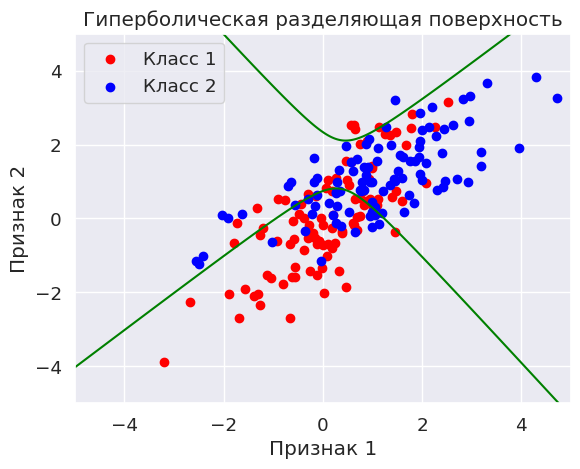

In [54]:
# построение графика
x1, x2 = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
Z = qda.predict_proba(np.c_[x1.ravel(), x2.ravel()])
Z = Z[:, 1].reshape(x1.shape)

fig, ax = plt.subplots()
ax.scatter(X1[:, 0], X1[:, 1], color='red', label='Класс 1')
ax.scatter(X2[:, 0], X2[:, 1], color='blue', label='Класс 2')
ax.contour(x1, x2, Z, levels=[0.5], colors='green')
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_title('Гиперболическая разделяющая поверхность')
ax.legend()
plt.show()

### Параболическая разделяющая поверность в квадратичном дискриминантном анализе
Разделяющая поверхность между двумя классами представляет собой параболу, когда ковариационная матрица каждого класса различна и не диагональна.

In [71]:
# генерация данные
np.random.seed(42)
X1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=100)
X2 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], size=100)
X = np.vstack([X1, X2])
y = np.concatenate([np.zeros(100), np.ones(100)])

In [72]:
# обучение модели
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)

QuadraticDiscriminantAnalysis()

In [73]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]

# Use the QDA model to predict the class of each point on the grid
Z = qda.predict(grid)
Z = Z.reshape(xx.shape)

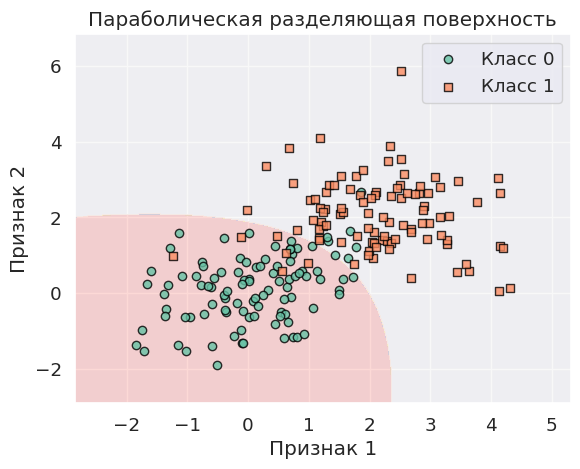

In [83]:
# визуализация параболической разделяющей поверхности
plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)

colors = ['#FFAAAA', '#AAFFAA']
markers = ['o', 's']
labels = ['Класс 0', 'Класс 1']
for i, color in enumerate(colors):
    idx = np.where(y == i)[0]
    plt.scatter(X[idx, 0], X[idx, 1], alpha=0.8,
                marker=markers[i], edgecolor='black', label=labels[i])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Параболическая разделяющая поверхность')
plt.legend()
plt.show()

### Две параллельные прямые в качестве разделяющей поверхности
Так как в квадратичном дискриминантном анализе разделяющая поверхность опеределяется квадратичной функцией, то невозможно разделить классы двумя параллельными линиями. Квадратичная функция может пересекать заданную линию не более двух раз. Если бы было две параллельные прямые, квадратичная функция должна была бы пересечь каждую из них как минимум дважды, что невозможно.

### Две пересекающиеся прямые в качестве разделяющей поверхности в квадратичном дискриминантном анализе

In [91]:
# генерация данных
np.random.seed(42)
n_samples = 100
X = np.concatenate((np.random.randn(n_samples, 2) + [2, 0], np.random.randn(n_samples, 2) + [-2, 0]))
y = np.concatenate((np.zeros(n_samples), np.ones(n_samples)))

In [92]:
# обучение модели
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)

QuadraticDiscriminantAnalysis()

In [93]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

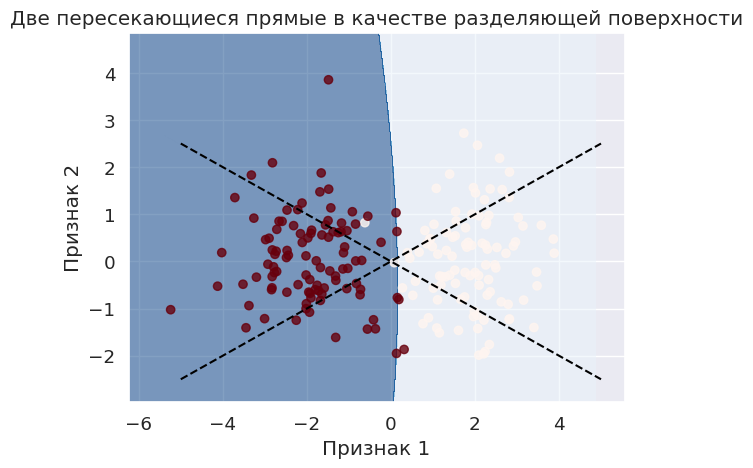

In [96]:
# визуализация разделяющей поверхности
cmap_boundary = plt.cm.Blues
cmap_points = plt.cm.Reds
plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap_boundary)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_points, alpha=0.8)

# пересекающиеся прямые
x1 = np.linspace(-5, 5, 100)
y1 = 0.5 * x1
y2 = -0.5 * x1
plt.plot(x1, y1, 'k--')
plt.plot(x1, y2, 'k--')

plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Две пересекающиеся прямые в качестве разделяющей поверхности')
plt.show()